In [275]:
import math, talib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf

In [276]:
stock = yf.Ticker('AAPL')
df = stock.history(start='2015-01-01', end='2022-01-17', interval='1d')
df = df.reset_index()

In [277]:
stock2 = yf.Ticker('MSFT')
df_MS = stock2.history(start='2018-12-24', end='2022-01-17', interval='1d')
df_MS = df_MS.reset_index()
df_MS.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-12-24,94.455956,94.736385,90.878082,91.023125,43935200,0.0,0
1,2018-12-26,91.999822,97.366643,90.858769,97.240929,51634800,0.0,0
2,2018-12-27,96.022493,97.850111,93.218209,97.840439,49498500,0.0,0
3,2018-12-28,98.720402,99.029847,96.235228,97.076515,38196300,0.0,0
4,2018-12-31,97.946826,99.020190,97.124882,98.217583,33173800,0.0,0


In [278]:
len(df_MS)

772

In [279]:
stock3 = yf.Ticker('TSLA')
df_TL = stock3.history(start='2018-12-24', end='2022-01-17', interval='1d')
df_TL = df_TL.reset_index()

In [280]:
print(len(df_TL))
df_TL.head()


772


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-12-24,62.700001,62.900002,59.040001,59.077999,27799500,0,0.0
1,2018-12-26,60.000000,65.393997,58.818001,65.218002,40815500,0,0.0
2,2018-12-27,63.967999,64.433998,60.299999,63.226002,42875500,0,0.0
3,2018-12-28,64.620003,67.248001,63.681999,66.774002,49695000,0,0.0
4,2018-12-31,67.557999,67.842003,65.052002,66.559998,31511500,0,0.0


## Data Preparation

In [281]:
# add more index and parameters

def index_add(df):

    df_new = df.copy()
    wma = talib.WMA(df_new['Close'])
    df_new['wma'] = wma

    ema = talib.EMA(df_new['Close'])
    df_new['ema'] = ema

    cci = talib.CCI(df_new['High'], df_new['Low'], df_new['Close'])
    df_new['cci'] = cci

    adx = talib.ADX(df_new['High'], df_new['Low'], df_new['Close'])
    df_new['adx'] = adx

    kama = talib.KAMA(df_new['Close'])
    df_new['kama'] = kama

    mom = talib.MOM(df_new['Close'])
    df_new['mon'] = mom

    willer = talib.WILLR(df_new['High'], df_new['Low'], df_new['Close'])
    df_new['willer'] = willer

    roc = talib.ROC(df_new['Close'])
    df_new['roc'] = roc

    rsi = talib.RSI(df_new['Close'])
    df_new['ris'] = rsi

    atr = talib.ATR(df_new['High'], df_new['Low'], df_new['Close'])
    df_new['atr'] = atr

    # drop the unrelated columns and drop the records with empty value
    df_new.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
    df_new.dropna(inplace= True)

    return df_new

df = index_add(df)
df_MS = index_add(df_MS)
df_TL = index_add(df_TL)

In [282]:
df.head()

,Date,Open,High,Low,Close,Volume,wma,ema,cci,adx,kama,mon,willer,roc,ris,atr
30,2015-02-13,28.922541,28.922541,28.552147,28.877094,217088800,26.620977,25.965267,158.129577,21.838551,28.745760,2.358841,-2.118728e+00,8.895160,72.806257,0.623608
31,2015-02-17,28.970257,29.286116,28.840733,29.047518,252609600,26.824415,26.164122,145.314439,23.842953,28.769789,2.196541,-7.487573e+00,8.180488,73.706834,0.610878
32,2015-02-18,29.002072,29.263393,28.961170,29.249760,179566800,27.031650,26.363195,123.200579,25.704182,28.824987,2.394251,-1.161530e+00,8.915306,74.774459,0.588831
33,2015-02-19,29.195223,29.320203,29.161139,29.188406,149449600,27.223742,26.545467,104.734972,27.483400,28.865617,2.126926,-4.326324e+00,7.859609,73.795510,0.558134
34,2015-02-20,29.227032,29.427000,29.097509,29.427000,195793600,27.420179,26.731372,94.893234,29.234331,28.927301,2.172373,1.126703e-13,7.970657,75.157594,0.541802


### Data Shift
In case we would like to predict the exact stock price tomorrow based on the historical data with certain time interval. We would like to shift our outcome variable up (-1) by one timestep.  In this project, we would like to explore the prediction performance of close price.

In [283]:
def data_shift(df):

    df_new = df.copy()

    # Create variable 'TOMORROW_CLOSE' which shifts 'Close' up by 1
    df_new['tomorrow_close'] = df_new['Close'].shift(-1,fill_value=0)

    # drop last row because we shifted value (remember this when you add your forecasting data)
    df_new.drop(df_new.tail(1).index,inplace=True) 

    # set Date as index
    df_new = df_new.set_index('Date')
    return df_new

df = data_shift(df)
df_MS = data_shift(df_MS)
df_TL = data_shift(df_TL)

In [284]:
print(len(df))
print(len(df_MS))
print(len(df_TL))
print(df.columns)
df.head()


1743
741
741
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'tomorrow_close'],
      dtype='object')


,Open,High,Low,Close,Volume,wma,ema,cci,adx,kama,mon,willer,roc,ris,atr,tomorrow_close
Date,,,,,,,,,,,,,,,,
2015-02-13,28.922541,28.922541,28.552147,28.877094,217088800,26.620977,25.965267,158.129577,21.838551,28.745760,2.358841,-2.118728e+00,8.895160,72.806257,0.623608,29.047518
2015-02-17,28.970257,29.286116,28.840733,29.047518,252609600,26.824415,26.164122,145.314439,23.842953,28.769789,2.196541,-7.487573e+00,8.180488,73.706834,0.610878,29.249760
2015-02-18,29.002072,29.263393,28.961170,29.249760,179566800,27.031650,26.363195,123.200579,25.704182,28.824987,2.394251,-1.161530e+00,8.915306,74.774459,0.588831,29.188406
2015-02-19,29.195223,29.320203,29.161139,29.188406,149449600,27.223742,26.545467,104.734972,27.483400,28.865617,2.126926,-4.326324e+00,7.859609,73.795510,0.558134,29.427000
2015-02-20,29.227032,29.427000,29.097509,29.427000,195793600,27.420179,26.731372,94.893234,29.234331,28.927301,2.172373,1.126703e-13,7.970657,75.157594,0.541802,30.222324


## Up or Down Prediction

[Reference](https://www.kaggle.com/szaitseff/classification-of-time-series-with-lstm-rnn)

In [285]:
# make target value, up as 1 and down as 0.
def direction_label(df):
    df1 = df.copy()
    df1['diff'] = df1['tomorrow_close'] - df1['Close']
    df1.loc[df1['diff'] >0, 'direction'] =1
    df1.loc[df1['diff'] <=0, 'direction'] =0
    # delete the column "diff".
    df1.drop(columns='diff', inplace=True)
    # delete the column "tomorrow_close".
    df1.drop(columns='tomorrow_close', inplace=True)

    return df1

df1 = direction_label(df)
df1_MS = direction_label(df_MS)
df1_TL = direction_label(df_TL)

In [286]:
print(len(df1))
print(len(df1_MS))
print(len(df1_TL))
print(df1.columns)

1743
741
741
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'direction'],
      dtype='object')


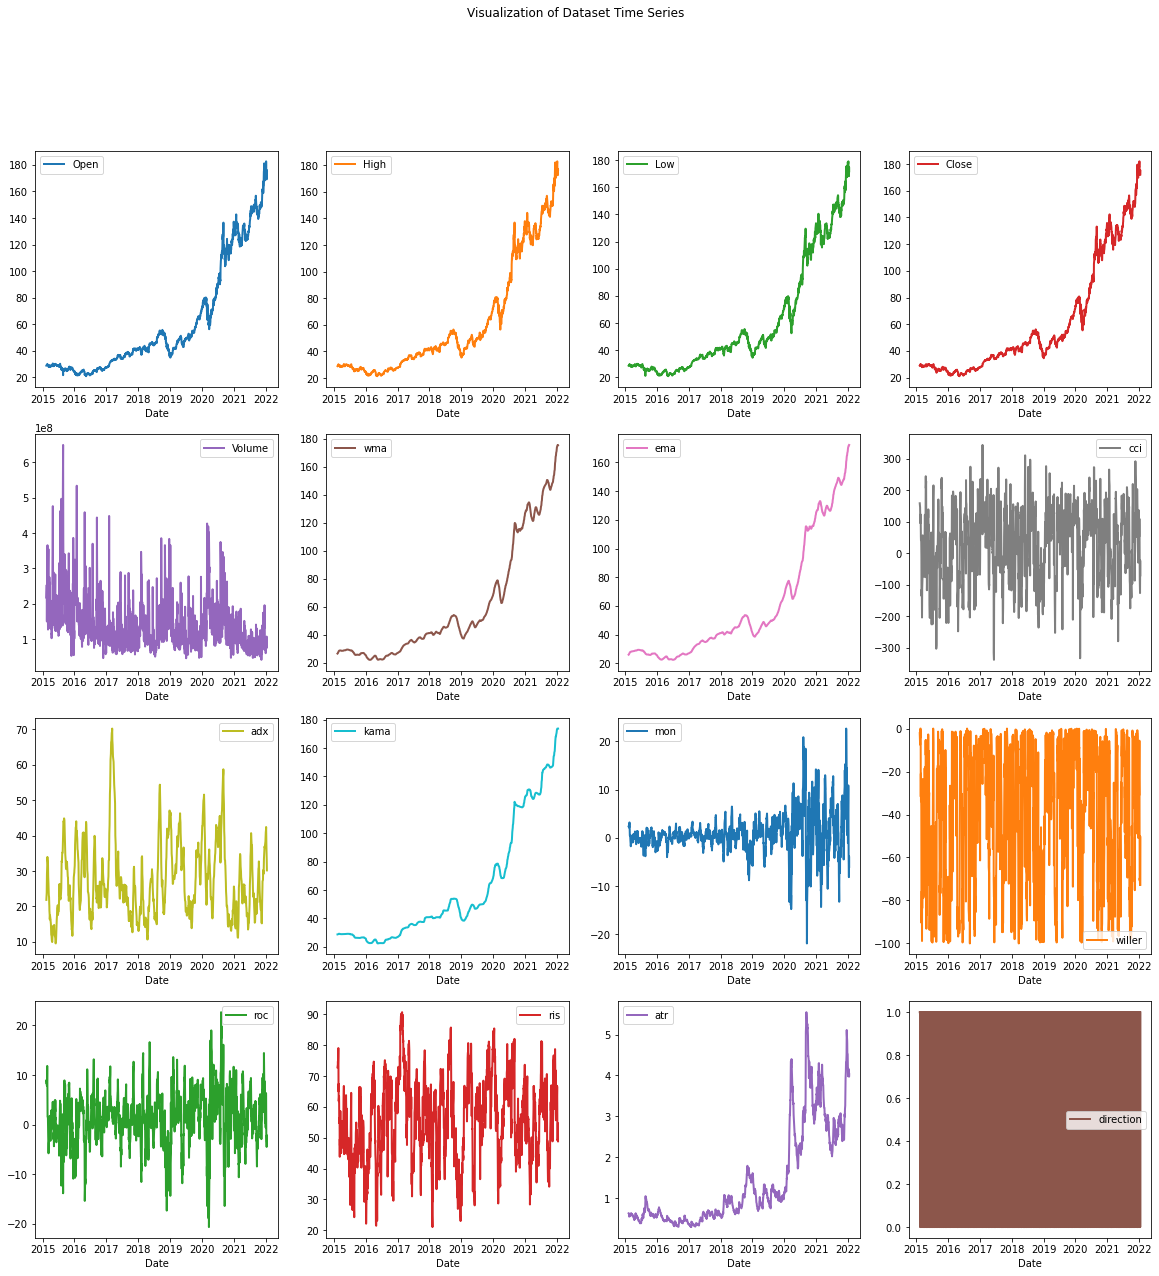

In [287]:
# Plot the time series
#plt.style.use('fivethirtyeight')
df1.plot(subplots=True,
        layout=(4, 4),
        figsize=(20,20),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of Dataset Time Series')
plt.show()

In [288]:
df1.corr()

,Open,High,Low,Close,Volume,wma,ema,cci,adx,kama,mon,willer,roc,ris,atr,direction
Open,1.000000,0.999862,0.999808,0.999655,-0.274928,0.997552,0.997048,0.089943,-0.029068,0.996947,0.248373,0.062401,0.130696,0.121367,0.868815,0.011932
High,0.999862,1.000000,0.999765,0.999823,-0.270131,0.997652,0.997150,0.090631,-0.028260,0.997137,0.249003,0.063295,0.130601,0.121305,0.871253,0.011605
Low,0.999808,0.999765,1.000000,0.999828,-0.281419,0.997353,0.996896,0.094985,-0.030826,0.996681,0.252404,0.068401,0.134775,0.125985,0.865123,0.011974
Close,0.999655,0.999823,0.999828,1.000000,-0.276276,0.997387,0.996918,0.095073,-0.029407,0.996807,0.253768,0.069885,0.135257,0.126155,0.867898,0.010742
Volume,-0.274928,-0.270131,-0.281419,-0.276276,1.000000,-0.266344,-0.266327,-0.257513,0.123821,-0.260192,-0.178009,-0.278966,-0.257401,-0.321385,-0.045766,-0.030284
wma,0.997552,0.997652,0.997353,0.997387,-0.266344,1.000000,0.999796,0.046371,-0.038722,0.999517,0.189982,0.019883,0.078964,0.074992,0.878581,0.011715
ema,0.997048,0.997150,0.996896,0.996918,-0.266327,0.999796,1.000000,0.045676,-0.044206,0.999502,0.189322,0.018995,0.077620,0.068198,0.879567,0.011805
cci,0.089943,0.090631,0.094985,0.095073,-0.257513,0.046371,0.045676,1.000000,0.079359,0.046872,0.631486,0.911911,0.770779,0.791610,-0.042499,0.021218
adx,-0.029068,-0.028260,-0.030826,-0.029407,0.123821,-0.038722,-0.044206,0.079359,1.000000,-0.030478,0.089243,0.112563,0.061148,0.261336,0.006270,0.020763
kama,0.996947,0.997137,0.996681,0.996807,-0.260192,0.999517,0.999502,0.046872,-0.030478,1.000000,0.191331,0.020890,0.079428,0.072743,0.886537,0.011886


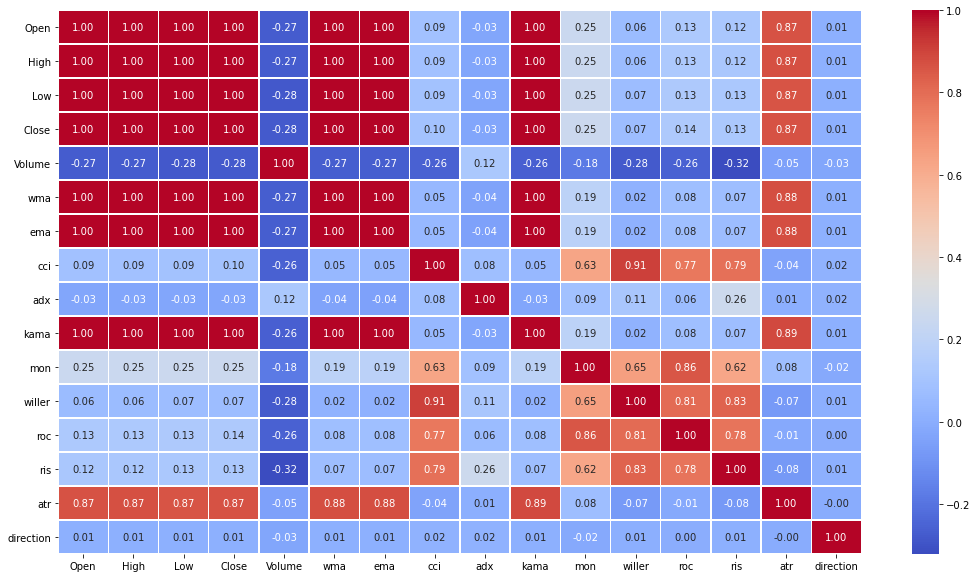

In [289]:
corr_matrix = df1.corr()
f, ax = plt.subplots(figsize=(18,10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Train Test Split

In [290]:
def data_split_direction(df):

    df1 = df.copy()
    # Split data into train (80%) and test (20%)
    train_size = int(len(df1)*0.8)
    train_set, test_set = df1.iloc[:train_size],df1.iloc[train_size:]

    # Split train data to X and y
    X_train = train_set.drop('direction', axis = 1)
    y_train = train_set.loc[:,['direction']]

    # Split test data to X and y
    X_test = test_set.drop('direction', axis = 1)
    y_test = test_set.loc[:,['direction']]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = data_split_direction(df1)
X_train_MS, y_train_MS, X_test_MS, y_test_MS = data_split_direction(df1_MS)
X_train_TL, y_train_TL, X_test_TL, y_test_TL = data_split_direction(df1_TL)

In [291]:
print(y_train.value_counts())
print(y_train_MS.value_counts())
print(y_train_TL.value_counts())

direction
1.0          740
0.0          654
dtype: int64
direction
1.0          337
0.0          255
dtype: int64
direction
1.0          315
0.0          277
dtype: int64


In [292]:
print(y_test.value_counts())
print(y_test_MS.value_counts())
print(y_test_TL.value_counts())

direction
1.0          184
0.0          165
dtype: int64
direction
1.0          79
0.0          70
dtype: int64
direction
1.0          88
0.0          61
dtype: int64


In [293]:
# Logistic Regression
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
out = lr.predict(X_test)

lr_MS = LogisticRegression(solver='liblinear')
lr_MS.fit(X_train_MS, y_train_MS)
out_MS = lr_MS.predict(X_test_MS)

print('Apple Accuracy score', accuracy_score(out, y_test))
print('Apple Precision score', precision_score(y_test, out, average='macro'))
print('Apple Recall score:', recall_score(y_test, out, average='macro'))
print('Apple F1 score:',  f1_score(y_test, out, average='macro'))
print('-' * 100)
print(classification_report(np.array(out), np.array(y_test), digits=4))
print('-' * 100)

print('Microsoft Accuracy score', accuracy_score(out_MS, y_test_MS))
print('Microsoft Precision score', precision_score(y_test_MS, out_MS, average='macro'))
print('Microsoft Recall score:', recall_score(y_test_MS, out_MS, average='macro'))
print('Microsoft F1 score:',  f1_score(y_test_MS, out_MS, average='macro'))
print('-' * 100)
print(classification_report(np.array(out_MS), np.array(y_test_MS), digits=4))
print('-' * 100)


Apple Accuracy score 0.5272206303724928
Apple Precision score 0.2636103151862464
Apple Recall score: 0.5
Apple F1 score: 0.3452157598499062
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000         0
         1.0     1.0000    0.5272    0.6904       349

    accuracy                         0.5272       349
   macro avg     0.5000    0.2636    0.3452       349
weighted avg     1.0000    0.5272    0.6904       349

----------------------------------------------------------------------------------------------------
Microsoft Accuracy score 0.5302013422818792
Microsoft Precision score 0.2651006711409396
Microsoft Recall score: 0.5
Microsoft F1 score: 0.34649122807017546
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0

In [294]:
lr_TL = LogisticRegression(solver='liblinear')
lr_TL.fit(X_train_TL, y_train_TL)
out_TL = lr_TL.predict(X_test_TL)

print('Tesla Accuracy score', accuracy_score(out_TL, y_test_TL))
print('Tesla Precision score', precision_score(y_test_TL, out_TL, average='macro'))
print('Tesla Recall score:', recall_score(y_test_TL, out_TL, average='macro'))
print('Tesla F1 score:',  f1_score(y_test_TL, out_TL, average='macro'))
print('-' * 100)
print(classification_report(np.array(out_TL), np.array(y_test_TL), digits=4))
print('-' * 100)

Tesla Accuracy score 0.5906040268456376
Tesla Precision score 0.2953020134228188
Tesla Recall score: 0.5
Tesla F1 score: 0.37130801687763715
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000         0
         1.0     1.0000    0.5906    0.7426       149

    accuracy                         0.5906       149
   macro avg     0.5000    0.2953    0.3713       149
weighted avg     1.0000    0.5906    0.7426       149

----------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Confusion Matrix by LR')

<Figure size 1152x1152 with 0 Axes>

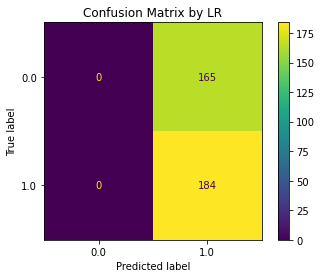

In [305]:
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize=(16, 16))
plot_confusion_matrix(lr, X_test, y_test)
plt.title('Confusion Matrix by LR')


In [296]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, out)
roc_auc = auc(fpr, tpr)
print ("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.500000


In [297]:
# SVM

clf = svm.SVC(random_state=42)
clf.fit(X_train, y_train)
out = clf.predict(X_test)

print('Apple Accuracy score', accuracy_score(out, y_test))
print('Apple Precision score', precision_score(y_test, out, average='macro'))
print('Apple Recall score:', recall_score(y_test, out, average='macro'))
print('Apple F1 score:',  f1_score(y_test, out, average='macro'))
print('-' * 100)
print(classification_report(np.array(out), np.array(y_test), digits=4))
print('-' * 100)


Apple Accuracy score 0.5214899713467048
Apple Precision score 0.4499633431085044
Apple Recall score: 0.49550395256916996
Apple F1 score: 0.3582934214148087
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.0182    0.3750    0.0347         8
         1.0     0.9728    0.5249    0.6819       341

    accuracy                         0.5215       349
   macro avg     0.4955    0.4500    0.3583       349
weighted avg     0.9509    0.5215    0.6671       349

----------------------------------------------------------------------------------------------------


In [298]:
clf_MS = svm.SVC(random_state=42)
clf_MS.fit(X_train_MS, y_train_MS)
out_MS = clf_MS.predict(X_test_MS)

print('Microsoft Accuracy score', accuracy_score(out_MS, y_test_MS))
print('Microsoft Precision score', precision_score(y_test_MS, out_MS, average='macro'))
print('Microsoft Recall score:', recall_score(y_test_MS, out_MS, average='macro'))
print('Microsoft F1 score:',  f1_score(y_test_MS, out_MS, average='macro'))
print('-' * 100)
print(classification_report(np.array(out_MS), np.array(y_test_MS), digits=4))
print('-' * 100)

Microsoft Accuracy score 0.5302013422818792
Microsoft Precision score 0.2651006711409396
Microsoft Recall score: 0.5
Microsoft F1 score: 0.34649122807017546
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000         0
         1.0     1.0000    0.5302    0.6930       149

    accuracy                         0.5302       149
   macro avg     0.5000    0.2651    0.3465       149
weighted avg     1.0000    0.5302    0.6930       149

----------------------------------------------------------------------------------------------------


In [299]:
clf_TL = svm.SVC(random_state=42)
clf_TL.fit(X_train_TL, y_train_TL)
out_TL = clf_TL.predict(X_test_TL)

print('Tesla Accuracy score', accuracy_score(out_TL, y_test_TL))
print('Tesla Precision score', precision_score(y_test_TL, out_TL, average='macro'))
print('Tesla Recall score:', recall_score(y_test_TL, out_TL, average='macro'))
print('Tesla F1 score:',  f1_score(y_test_TL, out_TL, average='macro'))
print('-' * 100)
print(classification_report(np.array(out_TL), np.array(y_test_TL), digits=4))
print('-' * 100)

Tesla Accuracy score 0.5906040268456376
Tesla Precision score 0.2953020134228188
Tesla Recall score: 0.5
Tesla F1 score: 0.37130801687763715
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000         0
         1.0     1.0000    0.5906    0.7426       149

    accuracy                         0.5906       149
   macro avg     0.5000    0.2953    0.3713       149
weighted avg     1.0000    0.5906    0.7426       149

----------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Confusion Matrix by SVM')

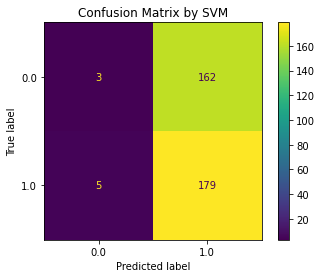

In [307]:
plot_confusion_matrix(clf, X_test, y_test)
plt.title("Confusion Matrix by SVM")

In [301]:
# random forest

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
out = rf.predict(X_test)

print('Apple Accuracy score', accuracy_score(out, y_test))
print('Apple Precision score', precision_score(y_test, out, average='macro'))
print('Apple Recall score:', recall_score(y_test, out, average='macro'))
print('Apple F1 score:',  f1_score(y_test, out, average='macro'))
print('-' * 100)
print(classification_report(np.array(out), np.array(y_test), digits=4))

Apple Accuracy score 0.5157593123209169
Apple Precision score 0.5065994674781286
Apple Recall score: 0.5057147562582345
Apple F1 score: 0.4929636793466581
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.3212    0.4818    0.3855       110
         1.0     0.6902    0.5314    0.6005       239

    accuracy                         0.5158       349
   macro avg     0.5057    0.5066    0.4930       349
weighted avg     0.5739    0.5158    0.5327       349



In [302]:
rf_MS = RandomForestClassifier(random_state=42)
rf_MS.fit(X_train_MS, y_train_MS)
out_MS = rf_MS.predict(X_test_MS)

print('Microsoft Accuracy score', accuracy_score(out_MS, y_test_MS))
print('Microsoft Precision score', precision_score(y_test_MS, out_MS, average='macro'))
print('Microsoft Recall score:', recall_score(y_test_MS, out_MS, average='macro'))
print('Microsoft F1 score:',  f1_score(y_test_MS, out_MS, average='macro'))
print('-' * 100)
print(classification_report(np.array(out_MS), np.array(y_test_MS), digits=4))
print('-' * 100)

Microsoft Accuracy score 0.46308724832214765
Microsoft Precision score 0.23310810810810811
Microsoft Recall score: 0.4928571428571429
Microsoft F1 score: 0.3165137614678899
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.9857    0.4662    0.6330       148
         1.0     0.0000    0.0000    0.0000         1

    accuracy                         0.4631       149
   macro avg     0.4929    0.2331    0.3165       149
weighted avg     0.9791    0.4631    0.6288       149

----------------------------------------------------------------------------------------------------


In [303]:
rf_TL = RandomForestClassifier(random_state=42)
rf_TL.fit(X_train_TL, y_train_TL)
out_TL = rf_TL.predict(X_test_TL)

print('Tesla Accuracy score', accuracy_score(out_TL, y_test_TL))
print('Tesla Precision score', precision_score(y_test_TL, out_TL, average='macro'))
print('Tesla Recall score:', recall_score(y_test_TL, out_TL, average='macro'))
print('Tesla F1 score:',  f1_score(y_test_TL, out_TL, average='macro'))
print('-' * 100)
print(classification_report(np.array(out_TL), np.array(y_test_TL), digits=4))
print('-' * 100)

Tesla Accuracy score 0.40939597315436244
Tesla Precision score 0.44421487603305787
Tesla Recall score: 0.4647913561847988
Tesla F1 score: 0.378931413414172
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.7705    0.3884    0.5165       121
         1.0     0.1591    0.5000    0.2414        28

    accuracy                         0.4094       149
   macro avg     0.4648    0.4442    0.3789       149
weighted avg     0.6556    0.4094    0.4648       149

----------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Confusion Matrix by RF')

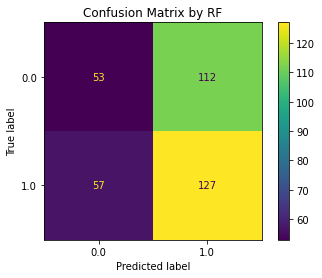

In [306]:
plot_confusion_matrix(rf, X_test, y_test)
plt.title("Confusion Matrix by RF")

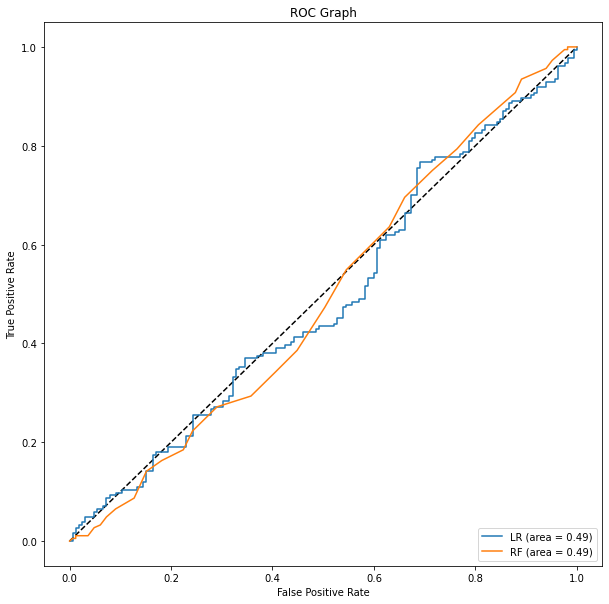

In [31]:
# ROC Graph 
from sklearn.metrics import roc_curve, auc

y_pred_prob1 = lr.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)
auc_1 = auc(fpr1, tpr1)
#y_pred_prob2 = clf.predict_proba(X_test)[:,1]
#fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)
#auc_2 = auc(fpr2, tpr2)
y_pred_prob3 = rf.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)
auc_3 = auc(fpr3, tpr3)

plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "LR (area = %0.2f)" % auc_1)
#plt.plot(fpr2, tpr2, label= "SVM (area = %0.2f)" % auc_2)
plt.plot(fpr3, tpr3, label= "RF (area = %0.2f)" % auc_3)
# plt.plot(fpr4, tpr4, label= "Sigmoid")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

The performance of all the three classifiers are not satisfied. I would like to check the feature importance first

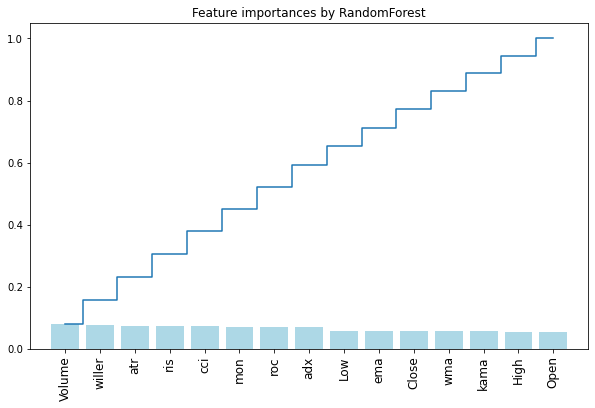

In [32]:
# plot feature importance of Random Forest
importances = rf.feature_importances_
feat_names = X_train.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature importances by RandomForest")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation=90,fontsize=12)
plt.xlim([-1, len(indices)])
plt.show()

In [33]:
"""
The performance of all the three ML models are not satisfied. 
We are going to try some DL models - RNN-based LSTM,

"""
from sklearn.preprocessing import MinMaxScaler
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

###################################

# Different scaler for input and output
scaler_x_MS = MinMaxScaler(feature_range = (-1,1))
scaler_y_MS = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler_MS = scaler_x_MS.fit(X_train_MS)
output_scaler_MS = scaler_y_MS.fit(y_train_MS)

# Apply the scaler to training data
train_y_norm_MS = output_scaler_MS.transform(y_train_MS)
train_x_norm_MS = input_scaler_MS.transform(X_train_MS)

# Apply the scaler to test data
test_y_norm_MS = output_scaler_MS.transform(y_test_MS)
test_x_norm_MS = input_scaler_MS.transform(X_test_MS)

####################################

# Different scaler for input and output
scaler_x_TL = MinMaxScaler(feature_range = (-1,1))
scaler_y_TL = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler_TL = scaler_x_TL.fit(X_train_TL)
output_scaler_TL = scaler_y_TL.fit(y_train_TL)

# Apply the scaler to training data
train_y_norm_TL = output_scaler_TL.transform(y_train_TL)
train_x_norm_TL = input_scaler_TL.transform(X_train_TL)

# Apply the scaler to test data
test_y_norm_TL = output_scaler_TL.transform(y_test_TL)
test_x_norm_TL = input_scaler_TL.transform(X_test_TL)


In [34]:
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 10

X_test, y_test = threeD_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = threeD_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1384, 10, 15)
y_train.shape:  (1384, 1)
X_test.shape:  (339, 10, 15)
y_test.shape:  (339, 1)


In [35]:
X_test_MS, y_test_MS = threeD_dataset(test_x_norm_MS, test_y_norm_MS, TIME_STEPS)
X_train_MS, y_train_MS = threeD_dataset(train_x_norm_MS, train_y_norm_MS, TIME_STEPS)

In [36]:
X_test_TL, y_test_TL = threeD_dataset(test_x_norm_TL, test_y_norm_TL, TIME_STEPS)
X_train_TL, y_train_TL = threeD_dataset(train_x_norm_TL, train_y_norm_TL, TIME_STEPS)

In [37]:
X_train.shape

(1384, 10, 15)

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [39]:
# Create LSTM classifier
def clf_LSTM(units, X_train):
    model = keras.Sequential()
    # First layer of LSTM
    model.add(LSTM(units = units, activation='tanh',return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.1)) 
    # Second layer of LSTM
    model.add(LSTM(units = units,activation='tanh'))                 
    model.add(Dropout(0.1))
    model.add(Dense(1)) 
    #Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# LSTM 
model_lstm = clf_LSTM(50, X_train)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            13200     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 33,451
Trainable params: 33,451
Non-trainable params: 0
_________________________________________________________________


In [40]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'accuracy',
                                               patience = 10)

# Set shuffle equal to False due to importance of oder for this dataset
model_lstm.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

"""
model_bilstm.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
"""

Epoch 1/100
35/35 [==============================] - 4s 29ms/step - loss: 0.7619 - accuracy: 0.4887 - val_loss: 2.2242 - val_accuracy: 0.4440
Epoch 2/100
35/35 [==============================] - 0s 9ms/step - loss: 0.7271 - accuracy: 0.4688 - val_loss: 1.8425 - val_accuracy: 0.4621
Epoch 3/100
35/35 [==============================] - 0s 10ms/step - loss: 0.7166 - accuracy: 0.4851 - val_loss: 1.7180 - val_accuracy: 0.4729
Epoch 4/100
35/35 [==============================] - 0s 10ms/step - loss: 0.7109 - accuracy: 0.4977 - val_loss: 1.5223 - val_accuracy: 0.4838
Epoch 5/100
35/35 [==============================] - 0s 10ms/step - loss: 0.7073 - accuracy: 0.4851 - val_loss: 1.5266 - val_accuracy: 0.4729
Epoch 6/100
35/35 [==============================] - 0s 9ms/step - loss: 0.7037 - accuracy: 0.4842 - val_loss: 1.4987 - val_accuracy: 0.4801
Epoch 7/100
35/35 [==============================] - 0s 9ms/step - loss: 0.7055 - accuracy: 0.4887 - val_loss: 1.5014 - val_accuracy: 0.4765
Epoch 8/1

'\nmodel_bilstm.fit(X_train, y_train, epochs = 100, validation_split = 0.2,\n                    batch_size = 32, shuffle = False, callbacks = [early_stop])\n'

In [41]:
# Final evaluation of the model
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D)

# LSTM:

train_loss, train_acc = model_lstm.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model_lstm.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('LSTM:')
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')
print('-'*100)


LSTM:
train accuracy = 51.7341%
test accuracy = 46.9027%
test error = 180 out of 339 examples
----------------------------------------------------------------------------------------------------


In [42]:
model_lstm_MS = clf_LSTM(50, X_train_MS)

model_lstm_MS.fit(X_train_MS, y_train_MS, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

# Final evaluation of the model
M_TRAIN = X_train_MS.shape[0]           # number of training examples (2D)
M_TEST = X_test_MS.shape[0]             # number of test examples (2D)

# LSTM:

train_loss, train_acc = model_lstm_MS.evaluate(X_train_MS, y_train_MS,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model_lstm_MS.evaluate(X_test_MS[:M_TEST], y_test_MS[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('Microsoft:')
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')
print('-'*100)

Epoch 1/100
15/15 [==============================] - 4s 57ms/step - loss: 2.9031 - accuracy: 0.4559 - val_loss: 8.0421 - val_accuracy: 0.4786
Epoch 2/100
15/15 [==============================] - 0s 9ms/step - loss: 4.5985 - accuracy: 0.5376 - val_loss: 6.7461 - val_accuracy: 0.4786
Epoch 3/100
15/15 [==============================] - 0s 9ms/step - loss: 0.8855 - accuracy: 0.5441 - val_loss: 0.7314 - val_accuracy: 0.5726
Epoch 4/100
15/15 [==============================] - 0s 9ms/step - loss: 0.7305 - accuracy: 0.5097 - val_loss: 0.7274 - val_accuracy: 0.5556
Epoch 5/100
15/15 [==============================] - 0s 9ms/step - loss: 0.7039 - accuracy: 0.5613 - val_loss: 0.6954 - val_accuracy: 0.5470
Epoch 6/100
15/15 [==============================] - 0s 9ms/step - loss: 0.6886 - accuracy: 0.5914 - val_loss: 0.6926 - val_accuracy: 0.5641
Epoch 7/100
15/15 [==============================] - 0s 9ms/step - loss: 0.6872 - accuracy: 0.5720 - val_loss: 0.6929 - val_accuracy: 0.5043
Epoch 8/100


In [43]:
model_lstm_TL = clf_LSTM(50, X_train_TL)

model_lstm_TL.fit(X_train_TL, y_train_TL, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

# Final evaluation of the model
M_TRAIN = X_train_TL.shape[0]           # number of training examples (2D)
M_TEST = X_test_TL.shape[0]             # number of test examples (2D)

# LSTM:

train_loss, train_acc = model_lstm_TL.evaluate(X_train_TL, y_train_TL,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model_lstm_TL.evaluate(X_test_TL[:M_TEST], y_test_TL[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('Tesla:')
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')
print('-'*100)

Epoch 1/100
15/15 [==============================] - 4s 74ms/step - loss: 2.7550 - accuracy: 0.4387 - val_loss: 7.5147 - val_accuracy: 0.5128
Epoch 2/100
15/15 [==============================] - 0s 10ms/step - loss: 1.4964 - accuracy: 0.4968 - val_loss: 7.3475 - val_accuracy: 0.5128
Epoch 3/100
15/15 [==============================] - 0s 11ms/step - loss: 0.9787 - accuracy: 0.4860 - val_loss: 6.9224 - val_accuracy: 0.5128
Epoch 4/100
15/15 [==============================] - 0s 10ms/step - loss: 0.7607 - accuracy: 0.4710 - val_loss: 2.9077 - val_accuracy: 0.5128
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 0.7425 - accuracy: 0.4860 - val_loss: 1.1751 - val_accuracy: 0.5128
Epoch 6/100
15/15 [==============================] - 0s 11ms/step - loss: 0.7257 - accuracy: 0.5247 - val_loss: 0.9624 - val_accuracy: 0.5128
Epoch 7/100
15/15 [==============================] - 0s 10ms/step - loss: 0.7121 - accuracy: 0.5161 - val_loss: 0.8609 - val_accuracy: 0.5128
Epoch 

## Close Price Prediction

Assuming the past information can affect the price today, we would like to use ARIMA, Auto-Regressive Integrated Moving Average Model and RNN-based deep learning model to forcast the close price change.

- Autoregressive Integrated Moving Average
- AR: autoregression means new observations depend on lagged observations
- I: use of differencing to make time series (more) stationary
- MA: residuals of previous observations propagate over time


The ARIMA model, or Auto-Regressive Integrated Moving Average model is fitted to the time series data for analyzing the data or to predict the future data points on a time scale. The biggest advantage of this model is that it can be applied in cases where the data shows evidence of non-stationarity. 

The auto-regressive means that the evolving variable of interest is regressed on its own prior value and moving average indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past. The significance of integration in the ARIMA model is that the data values have been replaced with the difference between their values and the previous values.

LSTM, or Long-Short-Term Memory Recurrent Neural Networks are the variants of Artificial Neural Networks. Unlike the feedforward networks where the signals travel in the forward direction only, in LSTM RNN, the data signals travel in backward directions as well as these networks have the feedback connections. The LSTM RNN is popularly used in time series forecasting.[Article](https://analyticsindiamag.com/comparing-arima-model-and-lstm-rnn-model-in-time-series-forecasting/)

In [44]:
print(df.columns)
df.head()

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'tomorrow_close'],
      dtype='object')


,Open,High,Low,Close,Volume,wma,ema,cci,adx,kama,mon,willer,roc,ris,atr,tomorrow_close
Date,,,,,,,,,,,,,,,,
2015-02-13,28.922535,28.922535,28.552142,28.877089,217088800,26.620978,25.965267,158.129349,21.838533,28.745758,2.358829,-2.118818e+00,8.895114,72.806284,0.623609,29.047514
2015-02-17,28.970253,29.286112,28.840729,29.047514,252609600,26.824415,26.164122,145.314503,23.842927,28.769787,2.196537,-7.487577e+00,8.180473,73.706873,0.610878,29.249758
2015-02-18,29.002070,29.263391,28.961168,29.249758,179566800,27.031650,26.363195,123.200768,25.704150,28.824985,2.394245,-1.161473e+00,8.915284,74.774509,0.588832,29.188404
2015-02-19,29.195221,29.320201,29.161137,29.188404,149449600,27.223742,26.545467,104.735117,27.483362,28.865615,2.126926,-4.326326e+00,7.859609,73.795557,0.558134,29.427000
2015-02-20,29.227032,29.427000,29.097509,29.427000,195793600,27.420179,26.731372,94.893474,29.234288,28.927299,2.172371,1.126703e-13,7.970649,75.157652,0.541802,30.222321


<Figure size 432x288 with 0 Axes>

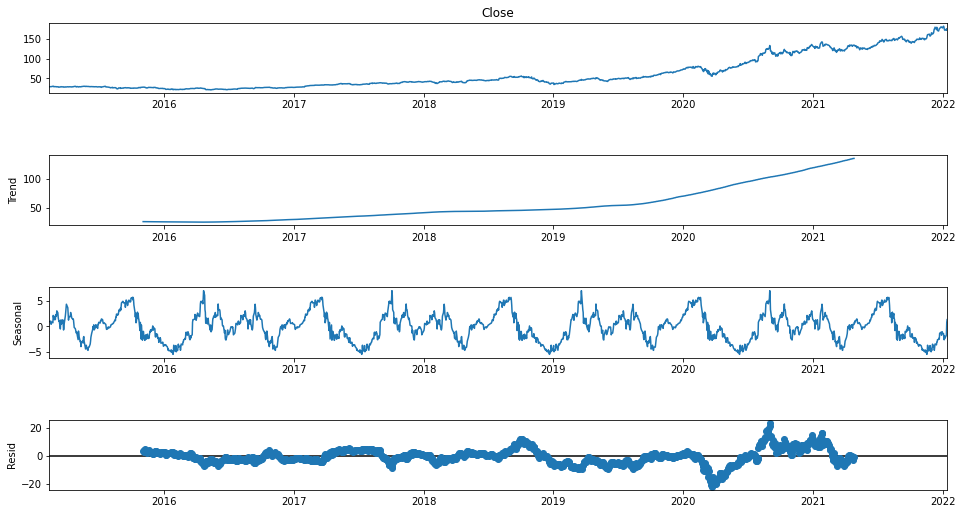

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df.Close, period=366)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
#plt.savefig('foo.png', bbox_inches='tight')
plt.show()

In [46]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(14).mean()
    rolstd = timeseries.rolling(14).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    

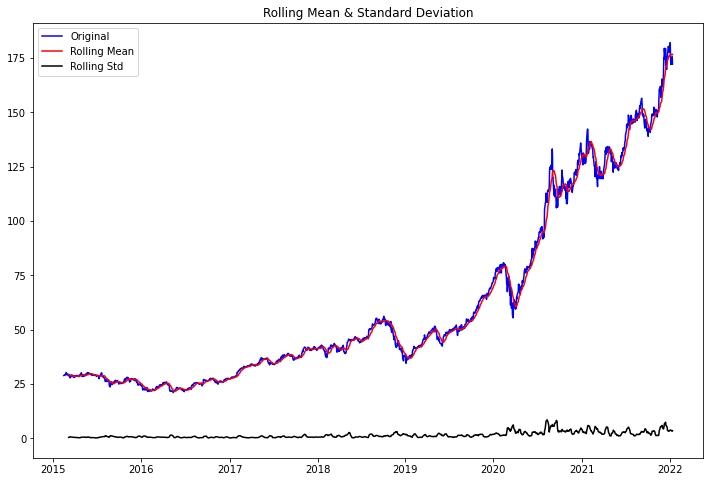

Results of Dickey-Fuller Test:
Test Statistic                    1.646072
p-value                           0.997989
#Lags Used                       20.000000
Number of Observations Used    1722.000000
Critical Value (1%)              -3.434153
Critical Value (5%)              -2.863220
Critical Value (10%)             -2.567664
dtype: float64


In [47]:
test_stationarity(df['Close'])


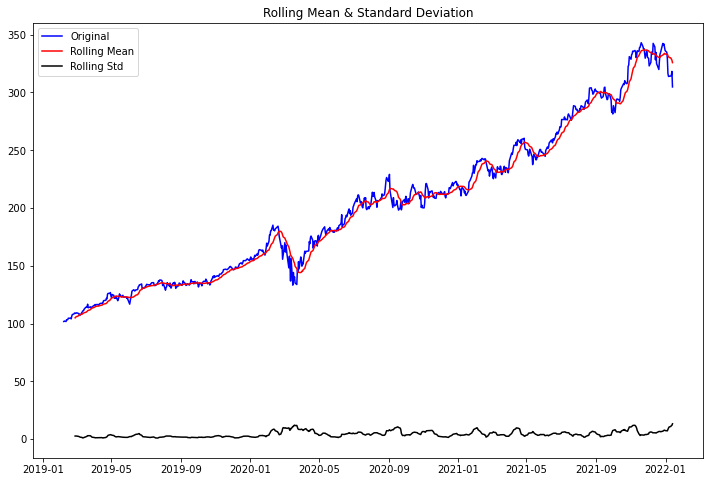

Results of Dickey-Fuller Test:
Test Statistic                  -0.433330
p-value                          0.904383
#Lags Used                      13.000000
Number of Observations Used    727.000000
Critical Value (1%)             -3.439377
Critical Value (5%)             -2.865524
Critical Value (10%)            -2.568891
dtype: float64


In [48]:
test_stationarity(df_MS['Close'])


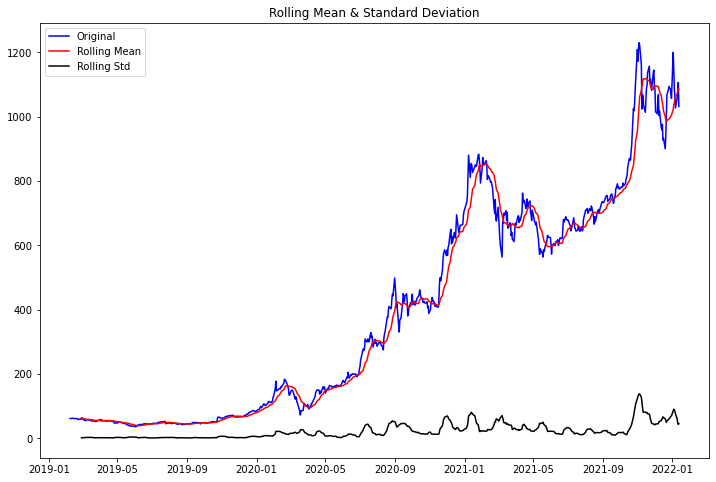

Results of Dickey-Fuller Test:
Test Statistic                   0.250315
p-value                          0.974947
#Lags Used                      20.000000
Number of Observations Used    720.000000
Critical Value (1%)             -3.439465
Critical Value (5%)             -2.865563
Critical Value (10%)            -2.568912
dtype: float64


In [49]:
test_stationarity(df_TL['Close'])

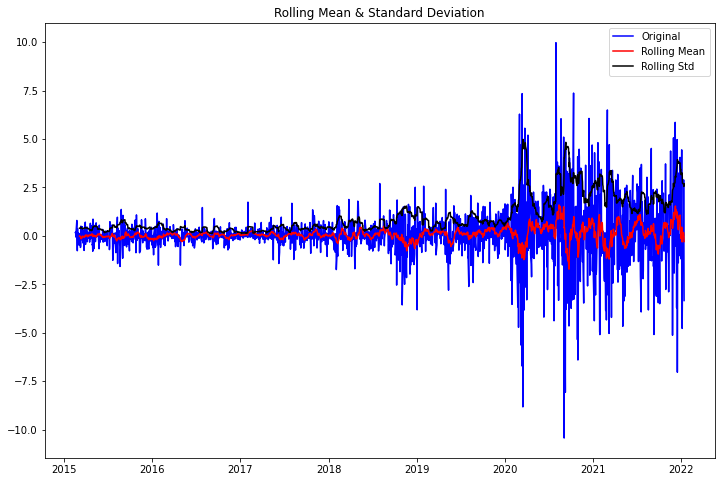

Results of Dickey-Fuller Test:
Test Statistic                -8.960287e+00
p-value                        8.259806e-15
#Lags Used                     2.500000e+01
Number of Observations Used    1.716000e+03
Critical Value (1%)           -3.434166e+00
Critical Value (5%)           -2.863226e+00
Critical Value (10%)          -2.567667e+00
dtype: float64


In [50]:
df2 = df.copy()
df2['first_difference'] = df2.Close - df2.Close.shift(1)  
test_stationarity(df2.first_difference.dropna(inplace=False))

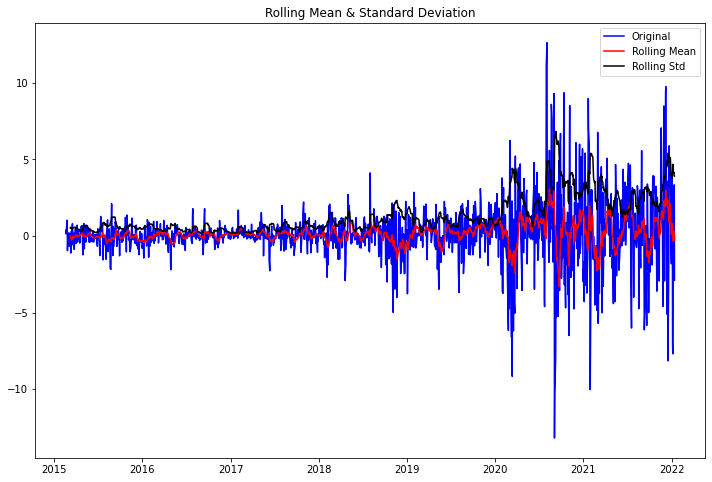

Results of Dickey-Fuller Test:
Test Statistic                -8.687796e+00
p-value                        4.118050e-14
#Lags Used                     2.300000e+01
Number of Observations Used    1.717000e+03
Critical Value (1%)           -3.434164e+00
Critical Value (5%)           -2.863225e+00
Critical Value (10%)          -2.567667e+00
dtype: float64


In [51]:
df2['second_difference'] = df2.Close - df2.Close.shift(2)  
test_stationarity(df2.second_difference.dropna(inplace=False))

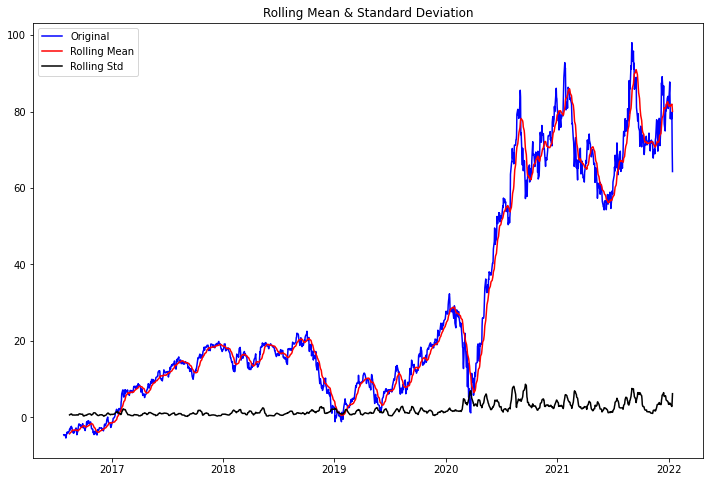

Results of Dickey-Fuller Test:
Test Statistic                   -1.236845
p-value                           0.657549
#Lags Used                       20.000000
Number of Observations Used    1356.000000
Critical Value (1%)              -3.435182
Critical Value (5%)              -2.863674
Critical Value (10%)             -2.567906
dtype: float64


In [52]:
df2['seasonal_difference'] = df2.Close - df2.Close.shift(366)  
test_stationarity(df2.seasonal_difference.dropna(inplace=False))

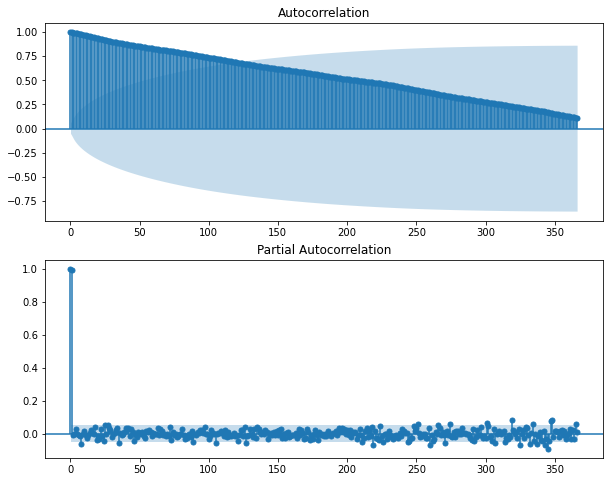

In [53]:
import statsmodels.api as sm 
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df2.Close.iloc[366:], lags=366, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df2.Close.iloc[366:], lags=366, ax=ax2)
plt.show()

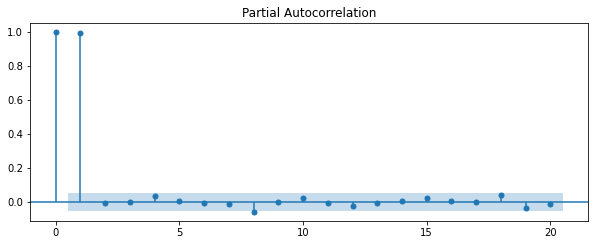

In [54]:
fig = plt.figure(figsize=(10,8))
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df2.Close.iloc[366:], lags=20, ax=ax2)
plt.show()

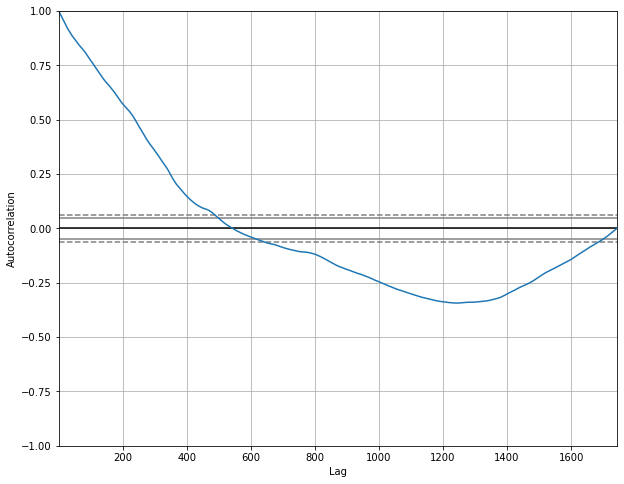

In [55]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(10,8))
autocorrelation_plot(df2.Close)
plt.show()

In [56]:
df2.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'tomorrow_close',
       'first_difference', 'second_difference', 'seasonal_difference'],
      dtype='object')

In [57]:
df2 = df.copy()
df2_MS = df_MS.copy()
df2_TL = df_TL.copy()

In [58]:
df_senti = pd.read_csv('BERT_barron_apple_150101.csv')
df_senti_MS = pd.read_csv('BERT_cnbc_msft_190101.csv')
df_senti_TL = pd.read_csv('BERT_cnbc_tsla_190101.csv')


In [59]:
def senti_treat(df):
    df_mean = df.groupby('date').agg({'Positive':'mean', 'Negative':'mean', 'Neutral':'mean'})
    df_mean = df_mean.reset_index()
    df_mean['date'] = pd.to_datetime(df_mean['date'])
    df_mean = df_mean.set_index('date')
    return df_mean

df_mean = senti_treat(df_senti)
df_mean_MS = senti_treat(df_senti)
df_mean_TL = senti_treat(df_senti)

In [60]:
df2 = df2.join(df_mean)
df2_MS = df2_MS.join(df_mean_MS)
df2_TL = df2_TL.join(df_mean_TL)
print(len(df2))
print(len(df2_MS))
print(len(df2_TL))

1743
741
741


In [61]:
df2_MS.head()

,Open,High,Low,Close,Volume,wma,ema,cci,adx,kama,mon,willer,roc,ris,atr,tomorrow_close,Positive,Negative,Neutral
Date,,,,,,,,,,,,,,,,,,,
2019-02-07,101.718087,102.104878,100.847791,101.795441,29760700,101.457169,100.237716,-30.660926,24.943756,102.501458,-0.899323,-45.898893,-0.875724,56.770285,2.407675,102.182251,0.143308,0.337105,0.519587
2019-02-08,100.944500,102.288621,100.818793,102.182251,21461100,101.566388,100.363170,-10.554853,23.689213,102.495703,-1.450493,-38.704017,-1.399647,57.550058,2.340686,101.776115,0.205493,0.366932,0.427575
2019-02-11,102.694757,103.062219,101.505358,101.776115,18914100,101.638777,100.454328,17.124564,22.892214,102.485284,0.164391,-46.059494,0.161783,56.399733,2.284699,103.361992,0.073796,0.242846,0.683358
2019-02-12,102.636746,103.603740,101.998534,103.361992,25056600,101.805018,100.641919,81.329346,22.403543,102.505529,3.819633,-17.337859,3.837194,59.780349,2.252050,103.284615,0.184934,0.286657,0.528409
2019-02-13,103.951843,104.222600,103.187917,103.284615,18394900,101.952749,100.812416,112.172637,22.232720,102.520106,0.415802,-18.739232,0.404206,59.537784,2.165096,103.371651,0.261478,0.156478,0.582043


In [62]:
# Split data into train (80%) and test (20%)
train_size = int(len(df2)*0.8)
train_set, test_set = df2.iloc[:train_size],df2.iloc[train_size:]

In [63]:
# Split train data to X and y
X_train_fin = train_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr']]
X_train_emo = train_set[['Positive', 'Negative', 'Neutral']]
X_train_combine = train_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'Positive', 'Negative', 'Neutral']]
y_train = train_set.loc[:,['tomorrow_close']]

# Split test data to X and y
X_test_fin = test_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr']]
X_test_emo = test_set[['Positive', 'Negative', 'Neutral']]
X_test_combine = test_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'Positive', 'Negative', 'Neutral']]

y_test = test_set.loc[:,['tomorrow_close']]

Dimension of train data:  (1394, 19)
Dimension of test data:  (349, 19)


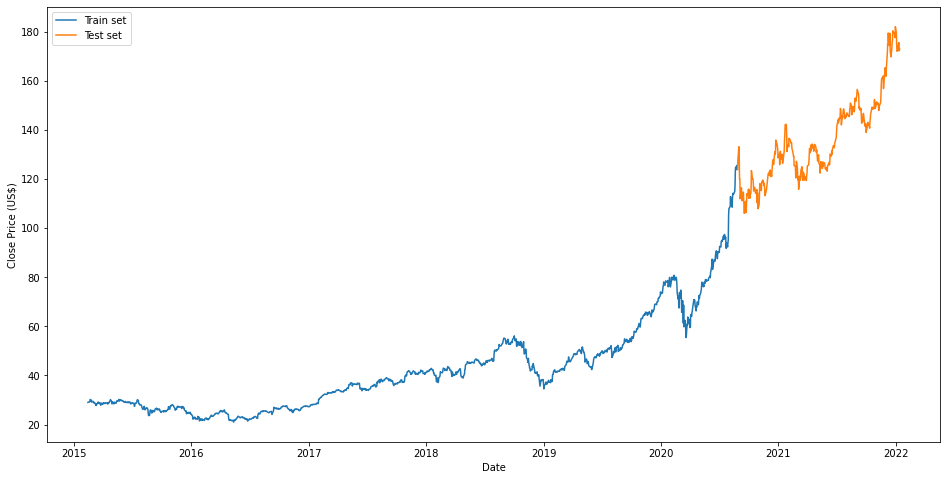

In [64]:
# Plot train and test data
plt.figure(figsize = (16, 8))
plt.plot(train_set.tomorrow_close)
plt.plot(test_set.tomorrow_close)
plt.xlabel('Date')
plt.ylabel('Close Price (US$)')
plt.legend(['Train set', 'Test set'], loc='upper left')
plt.title
print('Dimension of train data: ',train_set.shape)
print('Dimension of test data: ', test_set.shape)

In [65]:
# Different scaler for input and output
scaler_x_fin = MinMaxScaler(feature_range = (-1,1))
scaler_x_emo = MinMaxScaler(feature_range = (-1,1))
scaler_x_combine = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available financial training data
input_scaler_fin = scaler_x_fin.fit(X_train_fin)
train_x_norm_fin = input_scaler_fin.transform(X_train_fin)
test_x_norm_fin = input_scaler_fin.transform(X_test_fin)

# Fit the scaler using available emotional data
input_scaler_emo = scaler_x_emo.fit(X_train_emo)
train_x_norm_emo = input_scaler_emo.transform(X_train_emo)
test_x_norm_emo = input_scaler_emo.transform(X_test_emo)

# Fit the scaler using available combine data
input_scaler_combine = scaler_x_combine.fit(X_train_combine)
train_x_norm_combine = input_scaler_combine.transform(X_train_combine)
test_x_norm_combine = input_scaler_combine.transform(X_test_combine)

################################

# scaler transformation y
scaler_y = MinMaxScaler(feature_range = (-1,1))
output_scaler = scaler_y.fit(y_train)
train_y_norm = output_scaler.transform(y_train)
test_y_norm = output_scaler.transform(y_test)


In [66]:
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 10

X_train_fin, y_train_fin = threeD_dataset(train_x_norm_fin, train_y_norm, TIME_STEPS)
X_test_fin, y_test_fin = threeD_dataset(test_x_norm_fin, test_y_norm, TIME_STEPS)

print('X_train.shape: ', X_train_fin.shape)
print('y_train.shape: ', y_train_fin.shape)
print('X_test.shape: ', X_test_fin.shape) 
print('y_test.shape: ', y_test_fin.shape)

X_train.shape:  (1384, 10, 15)
y_train.shape:  (1384, 1)
X_test.shape:  (339, 10, 15)
y_test.shape:  (339, 1)


In [67]:
X_train_emo, y_train_emo = threeD_dataset(train_x_norm_emo, train_y_norm, TIME_STEPS)
X_test_emo, y_test_emo = threeD_dataset(test_x_norm_emo, test_y_norm, TIME_STEPS)

X_train_combine, y_train_combine = threeD_dataset(train_x_norm_combine, train_y_norm, TIME_STEPS)
X_test_combine, y_test_combine = threeD_dataset(test_x_norm_combine, test_y_norm, TIME_STEPS)

In [68]:
print('X_train.shape: ', X_train_emo.shape)
print('y_train.shape: ', y_train_emo.shape)
print('X_test.shape: ', X_test_emo.shape) 
print('y_test.shape: ', y_test_emo.shape)

X_train.shape:  (1384, 10, 3)
y_train.shape:  (1384, 1)
X_test.shape:  (339, 10, 3)
y_test.shape:  (339, 1)


### Deep Learning

In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [70]:
# predict by deep learning model
# Create BiLSTM model
def reg_bilstm(units, X_train):
    model = keras.Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# BiLSTM
model_bilstm = reg_bilstm(50)

# Create LSTM
def reg_LSTM(units, X_train):
    model = keras.Sequential()
    # First layer of LSTM
    model.add(LSTM(units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.1)) 
    # Second layer of LSTM
    model.add(LSTM(units = units))                 
    model.add(Dropout(0.1))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


model_lstm_fin = reg_LSTM(50, X_train_fin)
model_lstm_emo = reg_LSTM(50, X_train_emo)
model_lstm_combine = reg_LSTM(50, X_train_combine)

In [71]:

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

model_lstm_fin.fit(X_train_fin, y_train_fin, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
                
model_lstm_emo.fit(X_train_emo, y_train_emo, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

model_lstm_combine.fit(X_train_combine, y_train_combine, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

Epoch 1/100
35/35 [==============================] - 4s 29ms/step - loss: 0.0497 - val_loss: 0.0291
Epoch 2/100
35/35 [==============================] - 0s 9ms/step - loss: 0.0157 - val_loss: 0.0200
Epoch 3/100
35/35 [==============================] - 0s 10ms/step - loss: 0.0167 - val_loss: 0.0274
Epoch 4/100
35/35 [==============================] - 0s 10ms/step - loss: 0.0258 - val_loss: 0.0257
Epoch 5/100
35/35 [==============================] - 0s 10ms/step - loss: 0.0332 - val_loss: 0.0238
Epoch 6/100
35/35 [==============================] - 0s 9ms/step - loss: 0.0380 - val_loss: 0.0175
Epoch 7/100
35/35 [==============================] - 0s 9ms/step - loss: 0.0343 - val_loss: 0.0181
Epoch 8/100
35/35 [==============================] - 0s 10ms/step - loss: 0.0308 - val_loss: 0.0117
Epoch 9/100
35/35 [==============================] - 0s 9ms/step - loss: 0.0196 - val_loss: 0.0100
Epoch 10/100
35/35 [==============================] - 0s 9ms/step - loss: 0.0113 - val_loss: 0.0108
Epoc

In [72]:
# Must inverse scaler_y to make predictions
y_test = scaler_y.inverse_transform(y_test_combine)
y_train = scaler_y.inverse_transform(y_train_combine)

In [73]:
def prediction(model, X_test):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction


prediction_fin = prediction(model_lstm_fin, X_test_fin)
prediction_emo = prediction(model_lstm_emo, X_test_emo)
prediction_combine = prediction(model_lstm_combine, X_test_combine)


In [74]:
print(len(prediction_fin))
print(len(prediction_emo))
print(len(prediction_combine))

339
339
339


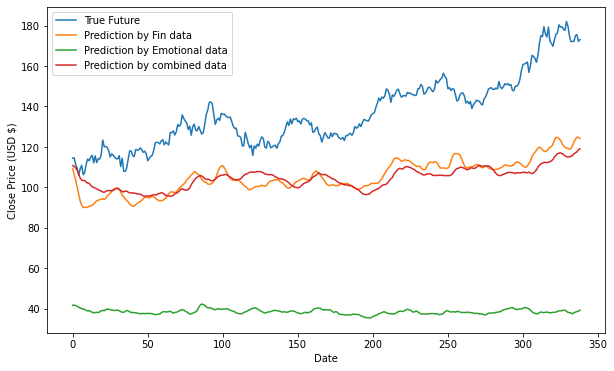

In [83]:
  
plt.figure(figsize=(10, 6))
range_future = len(prediction_fin)

plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
plt.plot(np.arange(range_future), np.array(prediction_fin),label='Prediction by Fin data')
plt.plot(np.arange(range_future), np.array(prediction_emo),label='Prediction by Emotional data')
plt.plot(np.arange(range_future), np.array(prediction_combine),label='Prediction by combined data')

#plt.title('AAPL - True future VS Prediction by LSTM Trained by Different Data')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Close Price (USD $)')
plt.show() 
    

In [81]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


In [82]:
print("Trained by Financial Data only:")
evaluate_prediction(prediction_fin, y_test)

print("Trained by Emotional Data only:")
evaluate_prediction(prediction_emo, y_test)

print("Trained by Combined Data:")
evaluate_prediction(prediction_combine, y_test)

Trained by Financial Data only:
Mean Absolute Error: 31.1037
Root Mean Square Error: 32.9327

Trained by Emotional Data only:
Mean Absolute Error: 97.9121
Root Mean Square Error: 99.4920

Trained by Combined Data:
Mean Absolute Error: 31.8806
Root Mean Square Error: 34.9085



#### Microsoft

In [84]:
# Split data into train (80%) and test (20%)
train_size = int(len(df2_MS)*0.8)
train_set, test_set = df2_MS.iloc[:train_size],df2_MS.iloc[train_size:]

# Split train data to X and y
X_train_fin = train_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr']]
X_train_emo = train_set[['Positive', 'Negative', 'Neutral']]
X_train_combine = train_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'Positive', 'Negative', 'Neutral']]
y_train = train_set.loc[:,['tomorrow_close']]

# Split test data to X and y
X_test_fin = test_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr']]
X_test_emo = test_set[['Positive', 'Negative', 'Neutral']]
X_test_combine = test_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'Positive', 'Negative', 'Neutral']]

y_test = test_set.loc[:,['tomorrow_close']]

In [85]:
# Different scaler for input and output
scaler_x_fin = MinMaxScaler(feature_range = (-1,1))
scaler_x_emo = MinMaxScaler(feature_range = (-1,1))
scaler_x_combine = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available financial training data
input_scaler_fin = scaler_x_fin.fit(X_train_fin)
train_x_norm_fin = input_scaler_fin.transform(X_train_fin)
test_x_norm_fin = input_scaler_fin.transform(X_test_fin)

# Fit the scaler using available emotional data
input_scaler_emo = scaler_x_emo.fit(X_train_emo)
train_x_norm_emo = input_scaler_emo.transform(X_train_emo)
test_x_norm_emo = input_scaler_emo.transform(X_test_emo)

# Fit the scaler using available combine data
input_scaler_combine = scaler_x_combine.fit(X_train_combine)
train_x_norm_combine = input_scaler_combine.transform(X_train_combine)
test_x_norm_combine = input_scaler_combine.transform(X_test_combine)

################################

# scaler transformation y
scaler_y = MinMaxScaler(feature_range = (-1,1))
output_scaler = scaler_y.fit(y_train)
train_y_norm = output_scaler.transform(y_train)
test_y_norm = output_scaler.transform(y_test)


In [86]:
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 10

X_train_fin, y_train_fin = threeD_dataset(train_x_norm_fin, train_y_norm, TIME_STEPS)
X_test_fin, y_test_fin = threeD_dataset(test_x_norm_fin, test_y_norm, TIME_STEPS)

print('X_train.shape: ', X_train_fin.shape)
print('y_train.shape: ', y_train_fin.shape)
print('X_test.shape: ', X_test_fin.shape) 
print('y_test.shape: ', y_test_fin.shape)

X_train.shape:  (582, 10, 15)
y_train.shape:  (582, 1)
X_test.shape:  (139, 10, 15)
y_test.shape:  (139, 1)


In [87]:
X_train_emo, y_train_emo = threeD_dataset(train_x_norm_emo, train_y_norm, TIME_STEPS)
X_test_emo, y_test_emo = threeD_dataset(test_x_norm_emo, test_y_norm, TIME_STEPS)

X_train_combine, y_train_combine = threeD_dataset(train_x_norm_combine, train_y_norm, TIME_STEPS)
X_test_combine, y_test_combine = threeD_dataset(test_x_norm_combine, test_y_norm, TIME_STEPS)

In [94]:
model_lstm_fin_MS = reg_LSTM(50, X_train_fin)
model_lstm_emo_MS = reg_LSTM(50, X_train_emo)
model_lstm_combine_MS = reg_LSTM(50, X_train_combine)

In [95]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

model_lstm_fin_MS.fit(X_train_fin, y_train_fin, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
                
model_lstm_emo_MS.fit(X_train_emo, y_train_emo, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

model_lstm_combine_MS.fit(X_train_combine, y_train_combine, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

Epoch 1/100
15/15 [==============================] - 4s 63ms/step - loss: 0.2404 - val_loss: 0.2366
Epoch 2/100
15/15 [==============================] - 0s 12ms/step - loss: 0.0217 - val_loss: 0.0395
Epoch 3/100
15/15 [==============================] - 0s 12ms/step - loss: 0.0290 - val_loss: 0.0121
Epoch 4/100
15/15 [==============================] - 0s 12ms/step - loss: 0.0122 - val_loss: 0.0654
Epoch 5/100
15/15 [==============================] - 0s 12ms/step - loss: 0.0134 - val_loss: 0.0372
Epoch 6/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0080 - val_loss: 0.0483
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0092 - val_loss: 0.0416
Epoch 8/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0077 - val_loss: 0.0590
Epoch 9/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0090 - val_loss: 0.0435
Epoch 10/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0081 - val_loss: 0.0734

In [90]:
# Must inverse scaler_y to make predictions
y_test = scaler_y.inverse_transform(y_test_combine)
y_train = scaler_y.inverse_transform(y_train_combine)

In [96]:
def prediction(model, X_test):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction


prediction_fin = prediction(model_lstm_fin_MS, X_test_fin)
prediction_emo = prediction(model_lstm_emo_MS, X_test_emo)
prediction_combine = prediction(model_lstm_combine_MS, X_test_combine)

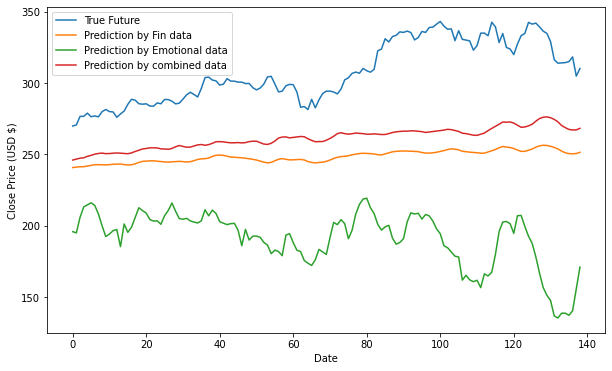

In [97]:
plt.figure(figsize=(10, 6))
range_future = len(prediction_fin)

plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
plt.plot(np.arange(range_future), np.array(prediction_fin),label='Prediction by Fin data')
plt.plot(np.arange(range_future), np.array(prediction_emo),label='Prediction by Emotional data')
plt.plot(np.arange(range_future), np.array(prediction_combine),label='Prediction by combined data')

#plt.title('AAPL - True future VS Prediction by LSTM Trained by Different Data')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Close Price (USD $)')
plt.show() 

In [98]:
print("Trained by Financial Data only:")
evaluate_prediction(prediction_fin, y_test)

print("Trained by Emotional Data only:")
evaluate_prediction(prediction_emo, y_test)

print("Trained by Combined Data:")
evaluate_prediction(prediction_combine, y_test)

Trained by Financial Data only:
Mean Absolute Error: 59.0055
Root Mean Square Error: 61.6170

Trained by Emotional Data only:
Mean Absolute Error: 116.1859
Root Mean Square Error: 120.7281

Trained by Combined Data:
Mean Absolute Error: 46.0140
Root Mean Square Error: 48.6727



#### Tesla

In [109]:
# Split data into train (80%) and test (20%)
train_size = int(len(df2_TL)*0.8)
train_set, test_set = df2_TL.iloc[:train_size],df2_TL.iloc[train_size:]

# Split train data to X and y
X_train_fin = train_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr']]
X_train_emo = train_set[['Positive', 'Negative', 'Neutral']]
X_train_combine = train_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'Positive', 'Negative', 'Neutral']]
y_train = train_set.loc[:,['tomorrow_close']]

# Split test data to X and y
X_test_fin = test_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr']]
X_test_emo = test_set[['Positive', 'Negative', 'Neutral']]
X_test_combine = test_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'Positive', 'Negative', 'Neutral']]

y_test = test_set.loc[:,['tomorrow_close']]

In [110]:
# Different scaler for input and output
scaler_x_fin = MinMaxScaler(feature_range = (-1,1))
scaler_x_emo = MinMaxScaler(feature_range = (-1,1))
scaler_x_combine = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available financial training data
input_scaler_fin = scaler_x_fin.fit(X_train_fin)
train_x_norm_fin = input_scaler_fin.transform(X_train_fin)
test_x_norm_fin = input_scaler_fin.transform(X_test_fin)

# Fit the scaler using available emotional data
input_scaler_emo = scaler_x_emo.fit(X_train_emo)
train_x_norm_emo = input_scaler_emo.transform(X_train_emo)
test_x_norm_emo = input_scaler_emo.transform(X_test_emo)

# Fit the scaler using available combine data
input_scaler_combine = scaler_x_combine.fit(X_train_combine)
train_x_norm_combine = input_scaler_combine.transform(X_train_combine)
test_x_norm_combine = input_scaler_combine.transform(X_test_combine)

################################

# scaler transformation y
scaler_y = MinMaxScaler(feature_range = (-1,1))
output_scaler = scaler_y.fit(y_train)
train_y_norm = output_scaler.transform(y_train)
test_y_norm = output_scaler.transform(y_test)


In [111]:
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 10

X_train_fin, y_train_fin = threeD_dataset(train_x_norm_fin, train_y_norm, TIME_STEPS)
X_test_fin, y_test_fin = threeD_dataset(test_x_norm_fin, test_y_norm, TIME_STEPS)

print('X_train.shape: ', X_train_fin.shape)
print('y_train.shape: ', y_train_fin.shape)
print('X_test.shape: ', X_test_fin.shape) 
print('y_test.shape: ', y_test_fin.shape)

X_train.shape:  (582, 10, 15)
y_train.shape:  (582, 1)
X_test.shape:  (139, 10, 15)
y_test.shape:  (139, 1)


In [112]:
X_train_emo, y_train_emo = threeD_dataset(train_x_norm_emo, train_y_norm, TIME_STEPS)
X_test_emo, y_test_emo = threeD_dataset(test_x_norm_emo, test_y_norm, TIME_STEPS)

X_train_combine, y_train_combine = threeD_dataset(train_x_norm_combine, train_y_norm, TIME_STEPS)
X_test_combine, y_test_combine = threeD_dataset(test_x_norm_combine, test_y_norm, TIME_STEPS)

In [119]:
model_lstm_fin_TL1 = reg_LSTM(50, X_train_fin)
model_lstm_emo_TL1 = reg_LSTM(50, X_train_emo)
model_lstm_combine_TL1 = reg_LSTM(50, X_train_combine)

In [120]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

model_lstm_fin_TL1.fit(X_train_fin, y_train_fin, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
                
model_lstm_emo_TL1.fit(X_train_emo, y_train_emo, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

model_lstm_combine_TL1.fit(X_train_combine, y_train_combine, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

Epoch 1/100
15/15 [==============================] - 4s 65ms/step - loss: 0.1965 - val_loss: 0.1110
Epoch 2/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0215 - val_loss: 0.0575
Epoch 3/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0174 - val_loss: 0.0179
Epoch 4/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0085 - val_loss: 0.0157
Epoch 5/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0102 - val_loss: 0.0143
Epoch 6/100
15/15 [==============================] - 0s 12ms/step - loss: 0.0085 - val_loss: 0.0150
Epoch 7/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0139
Epoch 8/100
15/15 [==============================] - 0s 12ms/step - loss: 0.0082 - val_loss: 0.0149
Epoch 9/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0151
Epoch 10/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0075 - val_loss: 0.0148

In [121]:
# Must inverse scaler_y to make predictions
y_test = scaler_y.inverse_transform(y_test_combine)
y_train = scaler_y.inverse_transform(y_train_combine)

In [122]:
def prediction(model, X_test):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction


prediction_fin = prediction(model_lstm_fin_TL1, X_test_fin)
prediction_emo = prediction(model_lstm_emo_TL1, X_test_emo)
prediction_combine = prediction(model_lstm_combine_TL1, X_test_combine)

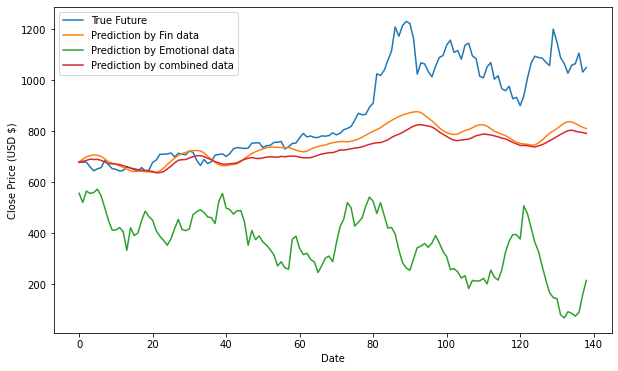

In [123]:
plt.figure(figsize=(10, 6))
range_future = len(prediction_fin)

plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
plt.plot(np.arange(range_future), np.array(prediction_fin),label='Prediction by Fin data')
plt.plot(np.arange(range_future), np.array(prediction_emo),label='Prediction by Emotional data')
plt.plot(np.arange(range_future), np.array(prediction_combine),label='Prediction by combined data')

#plt.title('AAPL - True future VS Prediction by LSTM Trained by Different Data')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Close Price (USD $)')
plt.show() 

In [124]:
print("Trained by Financial Data only:")
evaluate_prediction(prediction_fin, y_test)

print("Trained by Emotional Data only:")
evaluate_prediction(prediction_emo, y_test)

print("Trained by Combined Data:")
evaluate_prediction(prediction_combine, y_test)

Trained by Financial Data only:
Mean Absolute Error: 127.9645
Root Mean Square Error: 175.5451

Trained by Emotional Data only:
Mean Absolute Error: 507.4121
Root Mean Square Error: 574.6141

Trained by Combined Data:
Mean Absolute Error: 148.9575
Root Mean Square Error: 198.4099



### ARIMA

[Reference](https://www.kaggle.com/nageshsingh/stock-market-forecasting-arima)

In [125]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [140]:
# Split data into train (80%) and test (20%)
train_size = int(len(df2)*0.8)
train_set, test_set = df2.iloc[:train_size],df2.iloc[train_size:]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3903.542, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3876.071, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3879.591, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3908.494, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3873.568, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3875.351, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3858.361, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3874.567, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3860.102, Time=1.79 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3859.991, Time=1.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3860.377, Time=1.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3844.996, Time=1.41 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3877.670, Time=0.81 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : 

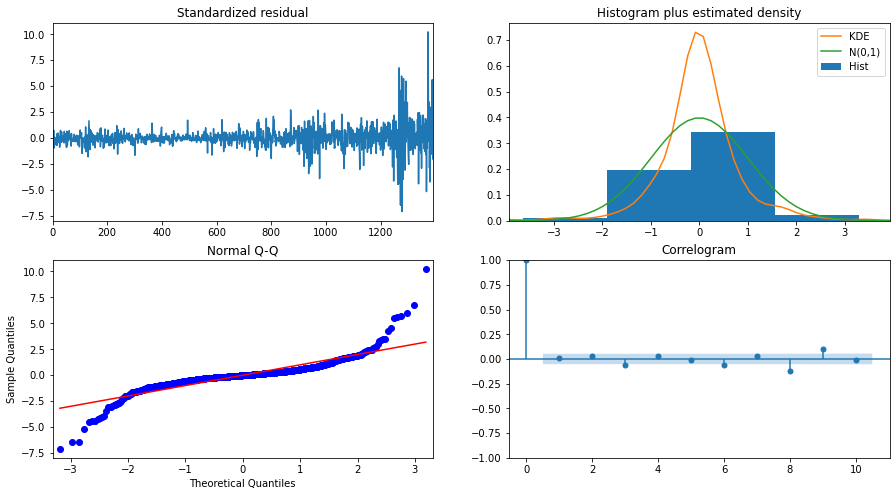

In [127]:
model_autoARIMA = auto_arima(train_set.Close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [141]:
#Modeling
# Build Model
model_ARIMA = ARIMA(train_set.Close, order=(3,1,2))  
fitted = model_ARIMA.fit(disp=-1)  
print(fitted.summary())

C:\Users\luobr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\luobr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1393
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1901.570
Method:                       css-mle   S.D. of innovations              0.947
Date:                Sat, 29 Jan 2022   AIC                           3817.139
Time:                        19:18:01   BIC                           3853.814
Sample:                             1   HQIC                          3830.853
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0692      0.024      2.872      0.004       0.022       0.116
ar.L1.D.Close    -1.7467      0.045    -39.173      0.000      -1.834      -1.659
ar.L2.D.Close    -0.9068      0.064    -

In [142]:
len(test_set)

349

In [143]:
# Forecast
fc, se, conf = fitted.forecast(349, alpha=0.05)  # 95% conf

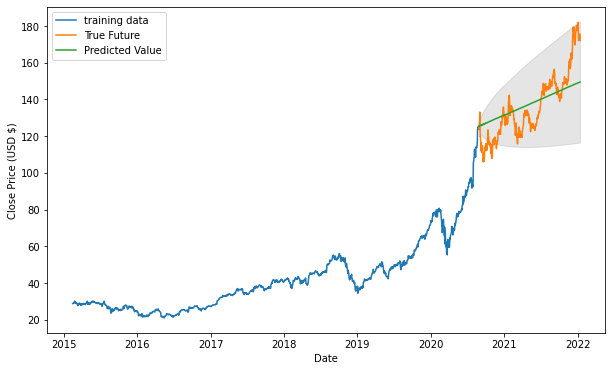

In [148]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_set.index)
lower_series = pd.Series(conf[:, 0], index=test_set.index)
upper_series = pd.Series(conf[:, 1], index=test_set.index)
# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_set.Close, label='training data')
plt.plot(test_set.Close, label='True Future')
plt.plot(fc_series,label='Predicted Value')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
#plt.title('AAPL Stock Price Prediction by ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price (USD $)')
plt.legend(loc='upper left')
plt.show()

In [145]:
# report performance
mse = mean_squared_error(test_set.Close, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_set.Close, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_set.Close, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_set.Close)/np.abs(test_set.Close))
print('MAPE: '+str(mape))

MSE: 139.11732949248378
MAE: 9.448960831549481
RMSE: 11.794800951795828
MAPE: 0.06999206980361719


In [136]:
len(test_set)

349

In [146]:
"""
pred = []
for i in range(len(test_set)):
    train_size = int(len(df2)*0.8) + i
    train_set, test_set = df2.iloc[:train_size],df2.iloc[train_size:]
    model_ARIMA1 = ARIMA(train_set.Close, order=(3,1,2))  
    fitted = model_ARIMA1.fit(disp=-1) 
    fc, se, conf = fitted.forecast(1, alpha=0.05)  # 95% conf
    pred.append(fc)
"""

'\npred = []\nfor i in range(len(test_set)):\n    train_size = int(len(df2)*0.8) + i\n    train_set, test_set = df2.iloc[:train_size],df2.iloc[train_size:]\n    model_ARIMA1 = ARIMA(train_set.Close, order=(3,1,2))  \n    fitted = model_ARIMA1.fit(disp=-1) \n    fc, se, conf = fitted.forecast(1, alpha=0.05)  # 95% conf\n    pred.append(fc)\n'

[SARIMAX Prediction](https://analyticsindiamag.com/comparing-arima-model-and-lstm-rnn-model-in-time-series-forecasting/)

In [ ]:
# Fit a SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SARIMAX = SARIMAX(df2['Close'],  order = (3, 1, 2))
result = model_SARIMAX.fit()
result.summary()

In [89]:
# Predictions for one-year against the test set 
start = len(train_set)
end = len(df2) - 1
predictions = result.predict(start, end, typ = 'levels').rename("Predictions") 

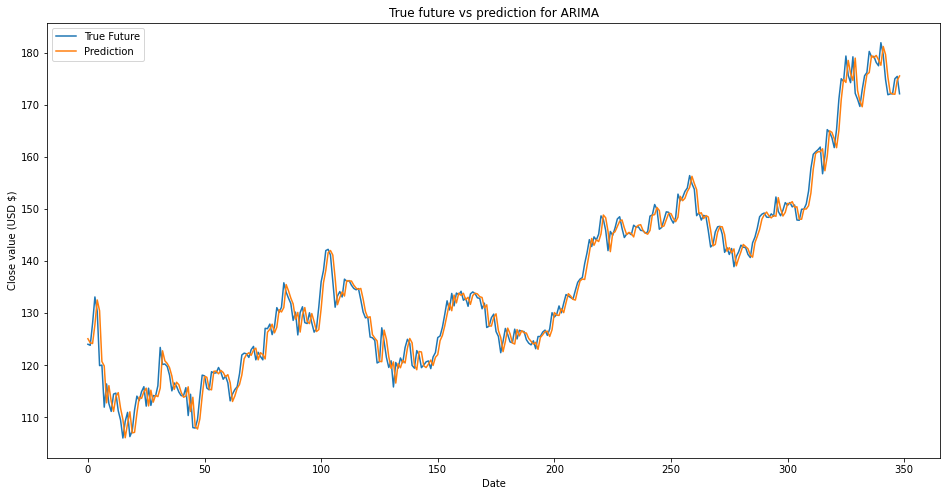

In [90]:
plot_future(predictions, 'ARIMA', test_set.Close)

In [91]:
# report performance
mse = mean_squared_error(test_set.Close, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_set.Close, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_set.Close, predictions))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions - test_set.Close)/np.abs(test_set.Close))
print('MAPE: '+str(mape))

MSE: 5.876766592950716
MAE: 1.8224398729265043
RMSE: 2.4242043216178617
MAPE: 0.01370062144406036


## Volatility

What does Volatility Means?

Volatility refers to amount of risk related to the amount person has invested on the stock. Say higher the volatility higher the risk, the price of the stock may go either high or low. If it is high well and good, If not ?. That’s where the tricky part comes. Hence it better to look for the stocks which are more stable. To understand more about volatility read this [article](https://www.investopedia.com/terms/v/volatility.asp).

In [149]:
df.head()

,Open,High,Low,Close,Volume,wma,ema,cci,adx,kama,mon,willer,roc,ris,atr,tomorrow_close
Date,,,,,,,,,,,,,,,,
2015-02-13,28.922535,28.922535,28.552142,28.877089,217088800,26.620978,25.965267,158.129349,21.838533,28.745758,2.358829,-2.118818e+00,8.895114,72.806284,0.623609,29.047514
2015-02-17,28.970253,29.286112,28.840729,29.047514,252609600,26.824415,26.164122,145.314503,23.842927,28.769787,2.196537,-7.487577e+00,8.180473,73.706873,0.610878,29.249758
2015-02-18,29.002070,29.263391,28.961168,29.249758,179566800,27.031650,26.363195,123.200768,25.704150,28.824985,2.394245,-1.161473e+00,8.915284,74.774509,0.588832,29.188404
2015-02-19,29.195221,29.320201,29.161137,29.188404,149449600,27.223742,26.545467,104.735117,27.483362,28.865615,2.126926,-4.326326e+00,7.859609,73.795557,0.558134,29.427000
2015-02-20,29.227032,29.427000,29.097509,29.427000,195793600,27.420179,26.731372,94.893474,29.234288,28.927299,2.172371,1.126703e-13,7.970649,75.157652,0.541802,30.222321


In [151]:
# Volatility Calculation for 10 days
df3 = df.copy()
df3_MS = df_MS.copy()
df3_TL = df_TL.copy()


In [152]:
def vola(df, window_size=1):
    df_new = df.copy()
    df_new['return'] = df_new['Close'].pct_change()
    df_new['volatility'] = df_new['return'].rolling(window_size).std()*(252**0.5)
    df_new.dropna(inplace=True)
    return df_new

In [153]:
df3 = vola(df3, window_size=10)
df3_MS = vola(df3_MS, window_size=10)
df3_TL = vola(df3_TL, window_size=10)

In [155]:
df3 = df3.join(df_mean)
df3_MS = df3_MS.join(df_mean_MS)
df3_TL= df3_TL.join(df_mean_TL)

In [157]:
print(len(df3))
print(len(df3_MS))
print(len(df3_TL))
df3.head()

1733
731
731


,Open,High,Low,Close,Volume,wma,ema,cci,adx,kama,...,willer,roc,ris,atr,tomorrow_close,return,volatility,Positive,Negative,Neutral
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-02,29.370194,29.604246,29.154321,29.333836,192386800,28.454370,27.670082,36.177224,32.595545,29.225413,...,-33.556595,1.581694,62.916603,0.594981,29.395191,0.004904,0.234274,0.240496,0.078736,0.680768
2015-03-03,29.304298,29.431550,29.106601,29.395191,151265200,28.577062,27.781379,14.915993,32.087860,29.246299,...,-38.198115,1.196926,63.388818,0.575693,29.208853,0.002092,0.233124,0.213344,0.157495,0.629161
2015-03-04,29.336108,29.440634,29.158864,29.208853,126665200,28.676108,27.873474,-12.882098,31.630429,29.242518,...,-63.013804,-0.139847,60.854363,0.554698,28.724840,-0.006339,0.233620,0.151392,0.091861,0.756747
2015-03-05,29.217941,29.256570,28.577137,28.724840,226068400,28.734033,27.928401,-136.352468,29.827998,29.203345,...,-90.440315,-1.588178,54.732850,0.563608,28.768017,-0.016571,0.248038,0.182915,0.218095,0.598990
2015-03-06,29.177040,29.397458,28.690758,28.768017,291368400,28.786294,27.982570,-116.181978,28.411621,29.175498,...,-89.285633,-2.239383,55.166112,0.573829,28.890724,0.001503,0.242969,0.173608,0.150586,0.675806


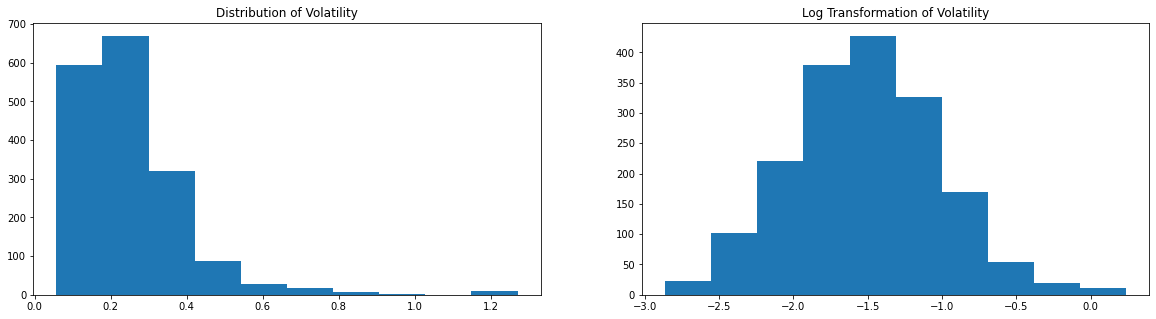

In [158]:
# plot volatility distribution

X = df3['volatility'].values
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(X)
plt.title('Distribution of Volatility')
plt.subplot(122)
plt.hist(np.log(X))
plt.title('Log Transformation of Volatility')
plt.show()

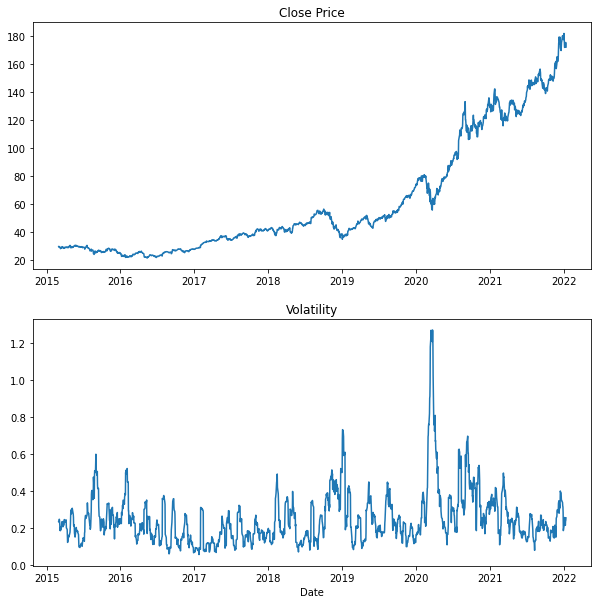

In [170]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(df3.Close)
plt.title('Close Price')
plt.subplot(212)
plt.plot(df3.volatility)
plt.xlabel('Date')
plt.title('Volatility')

plt.show()


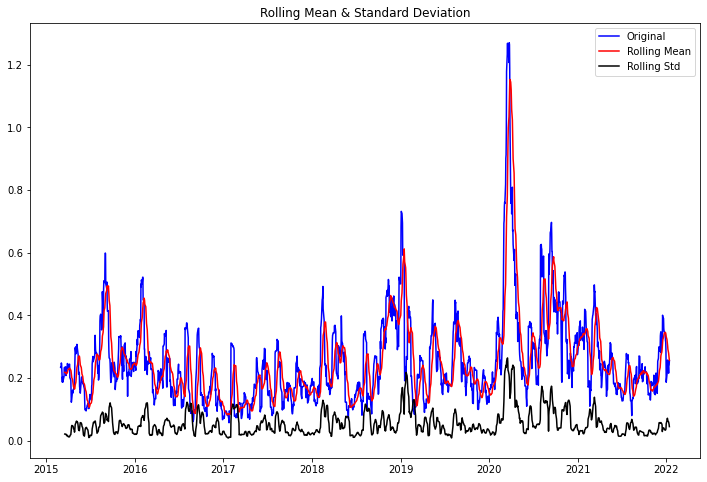

Results of Dickey-Fuller Test:
Test Statistic                   -4.732174
p-value                           0.000073
#Lags Used                       21.000000
Number of Observations Used    1711.000000
Critical Value (1%)              -3.434178
Critical Value (5%)              -2.863231
Critical Value (10%)             -2.567670
dtype: float64


In [160]:
test_stationarity(df3['volatility'])

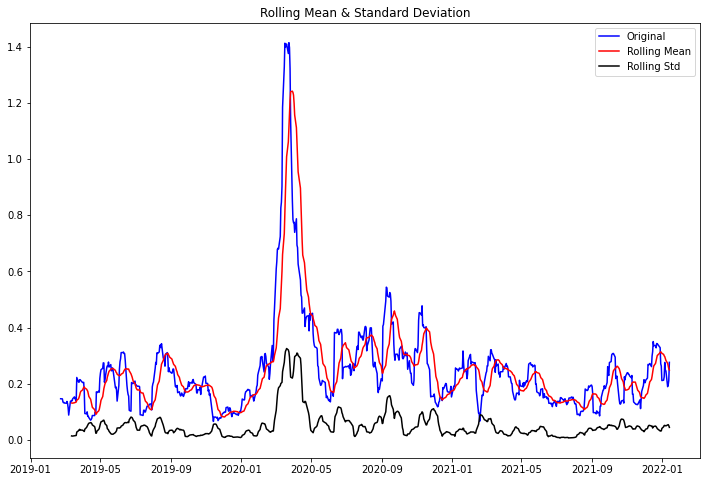

Results of Dickey-Fuller Test:
Test Statistic                  -2.811534
p-value                          0.056645
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


In [161]:
test_stationarity(df3_MS['volatility'])

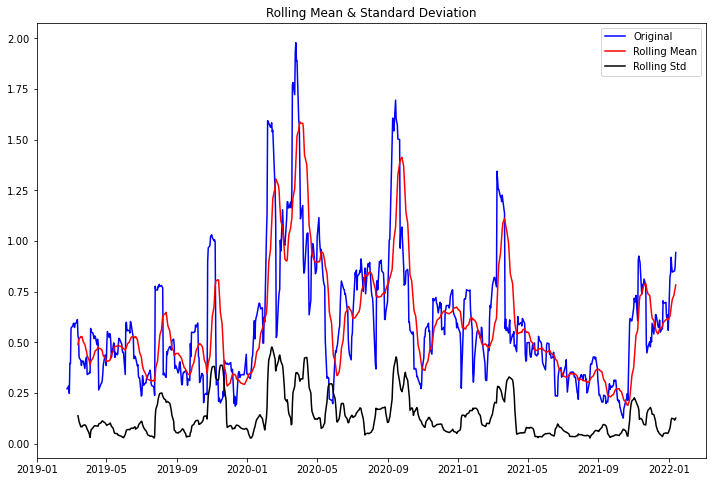

Results of Dickey-Fuller Test:
Test Statistic                  -2.727006
p-value                          0.069481
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


In [162]:
test_stationarity(df3_TL['volatility'])

Since the p-values is less than 5%, the data is stationary, means the volatility is not dependent on trend/time

<AxesSubplot:>

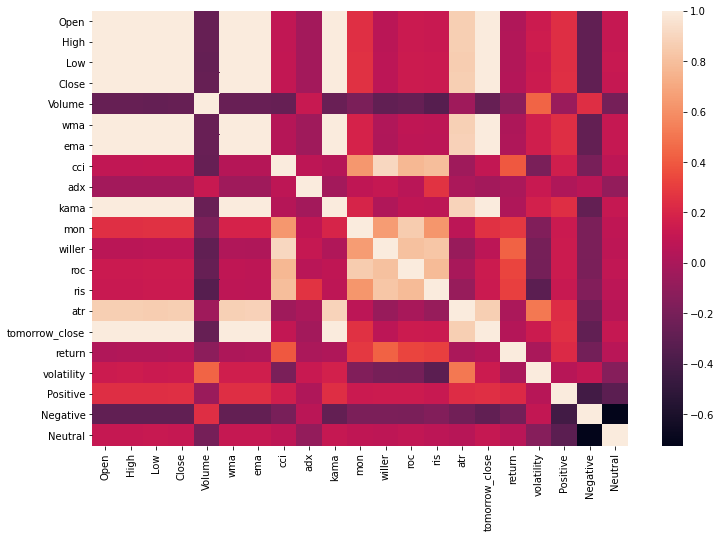

In [163]:
plt.figure(figsize=(12,8))
sns.heatmap(df3.corr())

From the first plot, the most important graph we need to observe is Volatility Vs other Columns(Last row). We can clearly see the data of Open, High, Low, Close, Adj. Close are very similarly relating to Volatility and the same is confirmed with the help of Heat map below. Which means that the contribution of these features to predict volatility is same, Hence not all the features are important.

In [172]:
df3.drop(columns=['tomorrow_close', 'return'], inplace=True)
df3_MS.drop(columns=['tomorrow_close', 'return'], inplace=True)
df3_TL.drop(columns=['tomorrow_close', 'return'], inplace=True)

In [173]:
df3.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'volatility', 'Positive',
       'Negative', 'Neutral'],
      dtype='object')

In [219]:
# Split data into train (80%) and test (20%)
train_size = int(len(df3)*0.8)
train_set, test_set = df3.iloc[:train_size],df3.iloc[train_size:]

In [220]:
# Split train data to X and y
X_train_fin = train_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr']]
X_train_emo = train_set[['Positive', 'Negative', 'Neutral']]
X_train_combine = train_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'Positive', 'Negative', 'Neutral']]
y_train = train_set.loc[:,['volatility']]

# Split test data to X and y
X_test_fin = test_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr']]
X_test_emo = test_set[['Positive', 'Negative', 'Neutral']]
X_test_combine = test_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'Positive', 'Negative', 'Neutral']]

y_test = test_set.loc[:,['volatility']]

Dimension of train data:  (1386, 19)
Dimension of test data:  (347, 19)


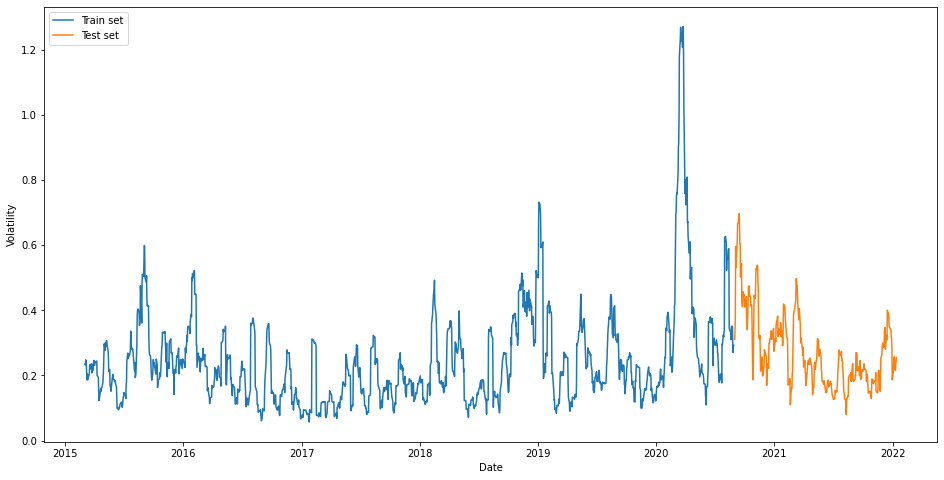

In [221]:
# Plot train and test data
plt.figure(figsize = (16, 8))
plt.plot(train_set.volatility)
plt.plot(test_set.volatility)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_set.shape)
print('Dimension of test data: ', test_set.shape)

In [222]:
# Different scaler for input and output
scaler_x_fin = MinMaxScaler(feature_range = (-1,1))
scaler_x_emo = MinMaxScaler(feature_range = (-1,1))
scaler_x_combine = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available financial training data
input_scaler_fin = scaler_x_fin.fit(X_train_fin)
train_x_norm_fin = input_scaler_fin.transform(X_train_fin)
test_x_norm_fin = input_scaler_fin.transform(X_test_fin)

# Fit the scaler using available emotional data
input_scaler_emo = scaler_x_emo.fit(X_train_emo)
train_x_norm_emo = input_scaler_emo.transform(X_train_emo)
test_x_norm_emo = input_scaler_emo.transform(X_test_emo)

# Fit the scaler using available combine data
input_scaler_combine = scaler_x_combine.fit(X_train_combine)
train_x_norm_combine = input_scaler_combine.transform(X_train_combine)
test_x_norm_combine = input_scaler_combine.transform(X_test_combine)

################################

# scaler transformation y
scaler_y = MinMaxScaler(feature_range = (-1,1))
output_scaler = scaler_y.fit(y_train)
train_y_norm = output_scaler.transform(y_train)
test_y_norm = output_scaler.transform(y_test)

In [223]:
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 10

X_train_fin, y_train_fin = threeD_dataset(train_x_norm_fin, train_y_norm, TIME_STEPS)
X_test_fin, y_test_fin = threeD_dataset(test_x_norm_fin, test_y_norm, TIME_STEPS)

print('X_train.shape: ', X_train_fin.shape)
print('y_train.shape: ', y_train_fin.shape)
print('X_test.shape: ', X_test_fin.shape) 
print('y_test.shape: ', y_test_fin.shape)

X_train.shape:  (1376, 10, 15)
y_train.shape:  (1376, 1)
X_test.shape:  (337, 10, 15)
y_test.shape:  (337, 1)


In [224]:
X_train_emo, y_train_emo = threeD_dataset(train_x_norm_emo, train_y_norm, TIME_STEPS)
X_test_emo, y_test_emo = threeD_dataset(test_x_norm_emo, test_y_norm, TIME_STEPS)

X_train_combine, y_train_combine = threeD_dataset(train_x_norm_combine, train_y_norm, TIME_STEPS)
X_test_combine, y_test_combine = threeD_dataset(test_x_norm_combine, test_y_norm, TIME_STEPS)

In [192]:
model_lstm_fin_AP1 = reg_LSTM(50, X_train_fin)
model_lstm_emo_AP1 = reg_LSTM(50, X_train_emo)
model_lstm_combine_AP1 = reg_LSTM(50, X_train_combine)

In [193]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

model_lstm_fin_AP1.fit(X_train_fin, y_train_fin, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
                
model_lstm_emo_AP1.fit(X_train_emo, y_train_emo, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

model_lstm_combine_AP1.fit(X_train_combine, y_train_combine, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])


Epoch 1/100
35/35 [==============================] - 6s 34ms/step - loss: 0.0829 - val_loss: 0.1477
Epoch 2/100
35/35 [==============================] - 0s 11ms/step - loss: 0.0300 - val_loss: 0.1289
Epoch 3/100
35/35 [==============================] - 0s 11ms/step - loss: 0.0223 - val_loss: 0.1103
Epoch 4/100
35/35 [==============================] - 0s 11ms/step - loss: 0.0200 - val_loss: 0.0888
Epoch 5/100
35/35 [==============================] - 0s 11ms/step - loss: 0.0190 - val_loss: 0.0739
Epoch 6/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0164 - val_loss: 0.0597
Epoch 7/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0165 - val_loss: 0.0508
Epoch 8/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0164 - val_loss: 0.0446
Epoch 9/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0152 - val_loss: 0.0410
Epoch 10/100
35/35 [==============================] - 0s 10ms/step - loss: 0.0168 - val_loss: 0.0378

In [225]:
# Must inverse scaler_y to make predictions
y_test_AP = scaler_y.inverse_transform(y_test_combine)
y_train_AP = scaler_y.inverse_transform(y_train_combine)

In [196]:
def prediction(model, X_test):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction


prediction_fin_AP1 = prediction(model_lstm_fin_AP1, X_test_fin)
prediction_emo_AP1 = prediction(model_lstm_emo_AP1, X_test_emo)
prediction_combine_AP1 = prediction(model_lstm_combine_AP1, X_test_combine)


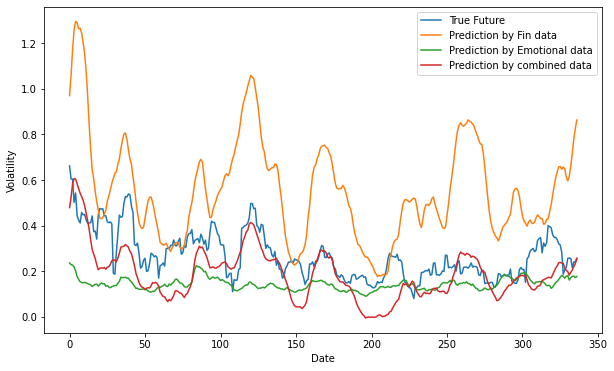

In [197]:
plt.figure(figsize=(10, 6))
range_future = len(prediction_fin_AP1)

plt.plot(np.arange(range_future), np.array(y_test_AP), label='True Future')
plt.plot(np.arange(range_future), np.array(prediction_fin_AP1),label='Prediction by Fin data')
plt.plot(np.arange(range_future), np.array(prediction_emo_AP1),label='Prediction by Emotional data')
plt.plot(np.arange(range_future), np.array(prediction_combine_AP1),label='Prediction by combined data')

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show() 

In [198]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


In [199]:
print("Trained by Financial Data only:")
evaluate_prediction(prediction_fin_AP1, y_test_AP)

print("Trained by Emotional Data only:")
evaluate_prediction(prediction_emo_AP1, y_test_AP)

print("Trained by Combined Data:")
evaluate_prediction(prediction_combine_AP1, y_test_AP)

Trained by Financial Data only:
Mean Absolute Error: 0.2879
Root Mean Square Error: 0.3468

Trained by Emotional Data only:
Mean Absolute Error: 0.1282
Root Mean Square Error: 0.1595

Trained by Combined Data:
Mean Absolute Error: 0.0988
Root Mean Square Error: 0.1220



In [213]:
# Create BiLSTM model
def reg_bilstm(units, X_train):
    model = keras.Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model



In [226]:
model_bilstm_fin_AP = reg_bilstm(50, X_train_fin)
model_bilstm_emo_AP = reg_bilstm(50, X_train_emo)
model_bilstm_combine_AP = reg_bilstm(50, X_train_combine)

In [227]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

model_bilstm_fin_AP.fit(X_train_fin, y_train_fin, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
                
model_bilstm_emo_AP.fit(X_train_emo, y_train_emo, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

model_bilstm_combine_AP.fit(X_train_combine, y_train_combine, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

Epoch 1/100
35/35 [==============================] - 11s 53ms/step - loss: 0.0853 - val_loss: 0.1212
Epoch 2/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0198 - val_loss: 0.1043
Epoch 3/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0163 - val_loss: 0.0836
Epoch 4/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0144 - val_loss: 0.0603
Epoch 5/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0136 - val_loss: 0.0469
Epoch 6/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0137 - val_loss: 0.0419
Epoch 7/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0135 - val_loss: 0.0402
Epoch 8/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0135 - val_loss: 0.0394
Epoch 9/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0135 - val_loss: 0.0388
Epoch 10/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0136 - val_loss: 0.038

In [228]:
prediction_fin_bi_AP = prediction(model_bilstm_fin_AP, X_test_fin)
prediction_emo_bi_AP = prediction(model_bilstm_emo_AP, X_test_emo)
prediction_combine_bi_AP = prediction(model_bilstm_combine_AP, X_test_combine)

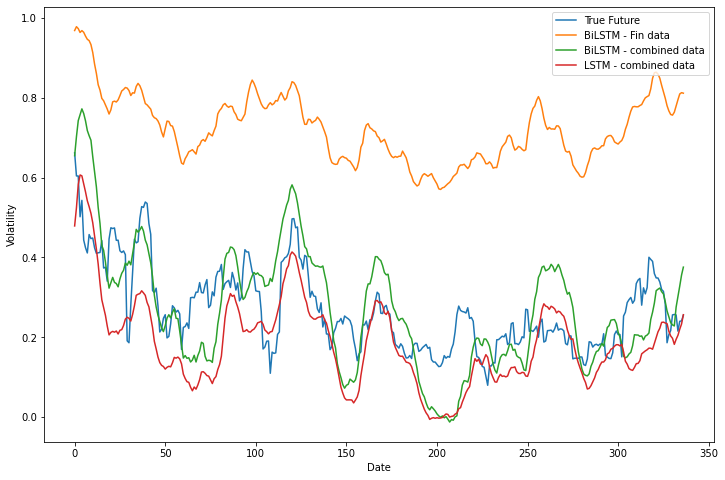

In [236]:
plt.figure(figsize=(12, 8))
range_future = len(prediction_fin_bi_AP)

plt.plot(np.arange(range_future), np.array(y_test_AP), label='True Future')
plt.plot(np.arange(range_future), np.array(prediction_fin_bi_AP),label='BiLSTM - Fin data')
#plt.plot(np.arange(range_future), np.array(prediction_emo_bi_AP),label='Prediction by Emotional data')
plt.plot(np.arange(range_future), np.array(prediction_combine_bi_AP),label='BiLSTM - combined data')
plt.plot(np.arange(range_future), np.array(prediction_combine_AP1),label='LSTM - combined data ')


plt.legend(loc='upper right')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show() 

In [235]:
print("BiLSTM Financial Data only:")
evaluate_prediction(prediction_fin_bi_AP, y_test_AP)

print("BiLSTM Combined Data:")
evaluate_prediction(prediction_combine_bi_AP, y_test_AP)

print("LSTM Combined Data:")
evaluate_prediction(prediction_combine_AP1, y_test_AP)

BiLSTM Financial Data only:
Mean Absolute Error: 0.4533
Root Mean Square Error: 0.4585

BiLSTM Combined Data:
Mean Absolute Error: 0.0938
Root Mean Square Error: 0.1123

LSTM Combined Data:
Mean Absolute Error: 0.0988
Root Mean Square Error: 0.1220



#### Microsoft

In [327]:
# Split data into train (80%) and test (20%)
train_size = int(len(df3_MS)*0.8)
train_set, test_set = df3_MS.iloc[:train_size],df3_MS.iloc[train_size:]

# Split train data to X and y

# Split train data to X and y
X_train = train_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'Positive', 'Negative', 'Neutral']]
y_train = train_set.loc[:,['volatility']]

# Split test data to X and y
X_test = test_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'Positive', 'Negative', 'Neutral']]
y_test = test_set.loc[:,['volatility']]

In [328]:

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [329]:
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)



TIME_STEPS = 10

X_test, y_test = threeD_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = threeD_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (574, 10, 18)
y_train.shape:  (574, 1)
X_test.shape:  (137, 10, 18)
y_test.shape:  (137, 1)


In [330]:
model_bilstm_MS = reg_bilstm(50, X_train)
model_lstm_MS = reg_LSTM(50, X_train)

In [331]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

model_bilstm_MS.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
model_lstm_MS.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

Epoch 1/100
15/15 [==============================] - 9s 141ms/step - loss: 0.3109 - val_loss: 0.4192
Epoch 2/100
15/15 [==============================] - 0s 16ms/step - loss: 0.1574 - val_loss: 0.0881
Epoch 3/100
15/15 [==============================] - 0s 15ms/step - loss: 0.1299 - val_loss: 0.0174
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0207 - val_loss: 0.0104
Epoch 5/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0157 - val_loss: 0.0037
Epoch 6/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0137 - val_loss: 0.0057
Epoch 7/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0126 - val_loss: 0.0037
Epoch 8/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0119 - val_loss: 0.0039
Epoch 9/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0113 - val_loss: 0.0044
Epoch 10/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0108 - val_loss: 0.004

In [332]:
# Must inverse scaler_y to make predictions
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [333]:
prediction_bilstm_MS = prediction(model_bilstm_MS, X_test)
prediction_lstm_MS = prediction(model_lstm_MS, X_test)
prediction_bilstm_MS_AP = prediction(model_bilstm_combine_AP, X_test)

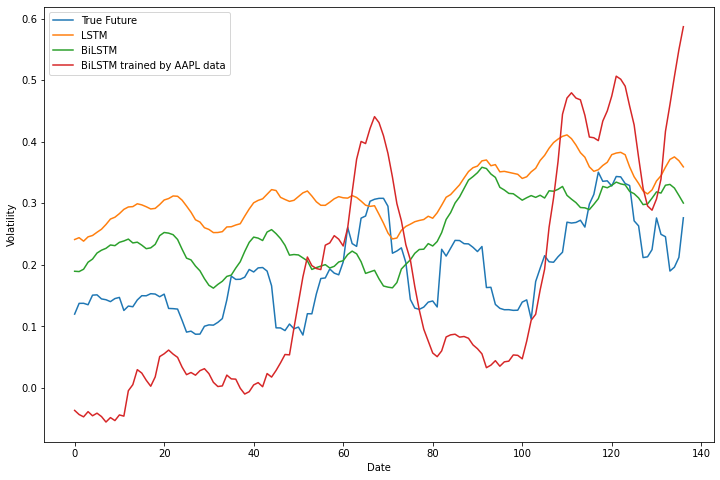

In [334]:
plt.figure(figsize=(12, 8))
range_future = len(prediction_bilstm_MS)

plt.plot(np.arange(range_future), np.array(y_test), label='True Future', )
plt.plot(np.arange(range_future), np.array(prediction_lstm_MS),label='LSTM')
plt.plot(np.arange(range_future), np.array(prediction_bilstm_MS),label='BiLSTM')
plt.plot(np.arange(range_future), np.array(prediction_bilstm_MS_AP),label='BiLSTM trained by AAPL data')

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show() 

In [335]:
print("LSTM:")
evaluate_prediction(prediction_lstm_MS, y_test)

print("BiLSTM:")
evaluate_prediction(prediction_bilstm_MS, y_test)

print("BiLSTM trained by AAPL data:")
evaluate_prediction(prediction_bilstm_MS_AP, y_test)

LSTM:
Mean Absolute Error: 0.1277
Root Mean Square Error: 0.1405

BiLSTM:
Mean Absolute Error: 0.0819
Root Mean Square Error: 0.0959

BiLSTM trained by AAPL data:
Mean Absolute Error: 0.1175
Root Mean Square Error: 0.1336



#### Tesla

In [318]:
# Split data into train (80%) and test (20%)
train_size = int(len(df3_TL)*0.8)
train_set, test_set = df3_TL.iloc[:train_size],df3_TL.iloc[train_size:]

# Split train data to X and y

# Split train data to X and y
X_train = train_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'Positive', 'Negative', 'Neutral']]
y_train = train_set.loc[:,['volatility']]

# Split test data to X and y
X_test = test_set[['Open', 'High', 'Low', 'Close', 'Volume', 'wma', 'ema', 'cci', 'adx',
       'kama', 'mon', 'willer', 'roc', 'ris', 'atr', 'Positive', 'Negative', 'Neutral']]
y_test = test_set.loc[:,['volatility']]

In [319]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [320]:
X_test, y_test = threeD_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = threeD_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (574, 10, 18)
y_train.shape:  (574, 1)
X_test.shape:  (137, 10, 18)
y_test.shape:  (137, 1)


In [321]:
model_bilstm_TL = reg_bilstm(50, X_train)
model_lstm_TL = reg_LSTM(50, X_train)

In [322]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

model_bilstm_TL.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
model_lstm_TL.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])

Epoch 1/100
15/15 [==============================] - 42s 132ms/step - loss: 0.2822 - val_loss: 0.2870
Epoch 2/100
15/15 [==============================] - 0s 20ms/step - loss: 0.1612 - val_loss: 0.1060
Epoch 3/100
15/15 [==============================] - 0s 22ms/step - loss: 0.1072 - val_loss: 0.0640
Epoch 4/100
15/15 [==============================] - 0s 21ms/step - loss: 0.1243 - val_loss: 0.0862
Epoch 5/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0942 - val_loss: 0.0609
Epoch 6/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0978 - val_loss: 0.0556
Epoch 7/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0797 - val_loss: 0.0526
Epoch 8/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0808 - val_loss: 0.0459
Epoch 9/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0653 - val_loss: 0.0491
Epoch 10/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0576 - val_loss: 0.04

In [323]:
# Must inverse scaler_y to make predictions
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [324]:
prediction_bilstm_TL = prediction(model_bilstm_TL, X_test)
prediction_lstm_TL = prediction(model_lstm_TL, X_test)
prediction_bilstm_TL_AP = prediction(model_bilstm_combine_AP, X_test)

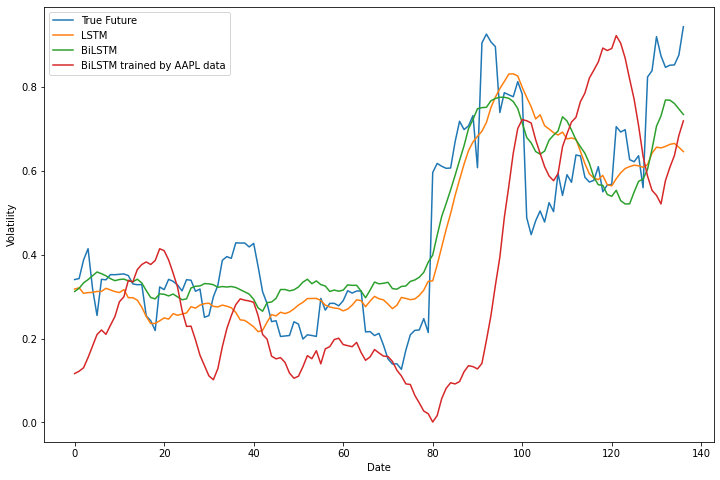

In [325]:
plt.figure(figsize=(12, 8))
range_future = len(prediction_bilstm_TL)

plt.plot(np.arange(range_future), np.array(y_test), label='True Future', )
plt.plot(np.arange(range_future), np.array(prediction_lstm_MS),label='LSTM')
plt.plot(np.arange(range_future), np.array(prediction_bilstm_MS),label='BiLSTM')
plt.plot(np.arange(range_future), np.array(prediction_bilstm_MS_AP),label='BiLSTM trained by AAPL data')

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show() 

In [326]:
print("LSTM:")
evaluate_prediction(prediction_lstm_MS, y_test)

print("BiLSTM:")
evaluate_prediction(prediction_bilstm_MS, y_test)

print("BiLSTM trained by AAPL data:")
evaluate_prediction(prediction_bilstm_MS_AP, y_test)

LSTM:
Mean Absolute Error: 0.0911
Root Mean Square Error: 0.1173

BiLSTM:
Mean Absolute Error: 0.0830
Root Mean Square Error: 0.1032

BiLSTM trained by AAPL data:
Mean Absolute Error: 0.1871
Root Mean Square Error: 0.2500

